# Overview
Option II - A: Tree and Ensemble Learning
This option will feature components from decision trees, random forests,  and ensemble learning. 

Use the Abalone dataset given in Part A: Option I. Now you need to apply CART for the sample problem and report the classification performance on the train and test set using the same train/test split.

## Import libraries

In [13]:
# import libraries
from sklearn import tree
import seaborn as sns

import numpy as np 
import pandas as pd
from sklearn import tree
import matplotlib
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split 

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
sns.set(rc={'figure.figsize':(10,6)})

In [14]:
# load and pre-process data
df = pd.read_csv('abalone.data', header =None)
# assign names to each data vector
df.columns =["Sex", 'Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera', 'Shell', 'AgeClass']
dataframe = df
print(dataframe.describe())

# change the continuous age variable to categorical AgeClass variable
ages = np.arange(0,31,dtype=int) # define a range of Ages
classes = np.concatenate((np.repeat(1,8),np.repeat(2,3),np.repeat(3,5),np.repeat(4,15))) #define the AgeClass
df['AgeClass'].replace(ages,classes,inplace=True) # replace Ages with AgeClass

#transform test and train data to numpy arrays
featureframe = dataframe.iloc[:,0:8]
ff = pd.get_dummies(featureframe, columns=None, drop_first=True) 
feature_names = ff.columns
features = pd.DataFrame(ff).to_numpy( )

targetframe = dataframe.iloc[:,8 ]
tf = targetframe
target_name = ['AgeClass']
target = pd.DataFrame(tf).to_numpy( )

#	Sex		nominal			M, F, and I (infant)
#	Length		continuous	mm	Longest shell measurement
#	Diameter	continuous	mm	perpendicular to length
#	Height		continuous	mm	with meat in shell
#	Whole weight	continuous	grams	whole abalone
#	Shucked weight	continuous	grams	weight of meat
#	Viscera weight	continuous	grams	gut weight (after bleeding)
#	Shell weight	continuous	grams	after being dried
#	Rings		integer			+1.5 gives the age in years

            Length     Diameter       Height        Whole      Shucked  \
count  4177.000000  4177.000000  4177.000000  4177.000000  4177.000000   
mean      0.523992     0.407881     0.139516     0.828742     0.359367   
std       0.120093     0.099240     0.041827     0.490389     0.221963   
min       0.075000     0.055000     0.000000     0.002000     0.001000   
25%       0.450000     0.350000     0.115000     0.441500     0.186000   
50%       0.545000     0.425000     0.140000     0.799500     0.336000   
75%       0.615000     0.480000     0.165000     1.153000     0.502000   
max       0.815000     0.650000     1.130000     2.825500     1.488000   

           Viscera        Shell     AgeClass  
count  4177.000000  4177.000000  4177.000000  
mean      0.180594     0.238831     9.933684  
std       0.109614     0.139203     3.224169  
min       0.000500     0.001500     1.000000  
25%       0.093500     0.130000     8.000000  
50%       0.171000     0.234000     9.000000  
75% 

In [4]:
# this function measures the accuracy of a decision tree for a particular set of hyperparameters
def short_process_data(min_in_leaf,tree_depth):

    max_expruns = 100
    perf_train = np.zeros(max_expruns)
    perf_test = np.zeros(max_expruns)  

    for run_num in range(0,max_expruns):
        # split data into test and train
        features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=run_num,test_size=0.40)
        # define classifier
        clf =  tree.DecisionTreeClassifier(random_state=run_num, min_samples_leaf=min_in_leaf, max_depth=tree_depth,class_weight='balanced')
        # train model
        decision_tree = clf.fit(features_train, target_train)
        # predict both test and train accuracy
        target_test_predicted = decision_tree.predict(features_test) # this is the test.  THIS is the one we want to breakout
        target_train_predicted = decision_tree.predict(features_train) #this is the train
        perf_test[run_num] = accuracy_score(target_test_predicted, target_test)
#        perf_train[run_num] = accuracy_score(target_train_predicted, target_train) 
    return np.mean(perf_test)


## Exploratory Data Analysis

Class sizes: 839 1891 1186 261


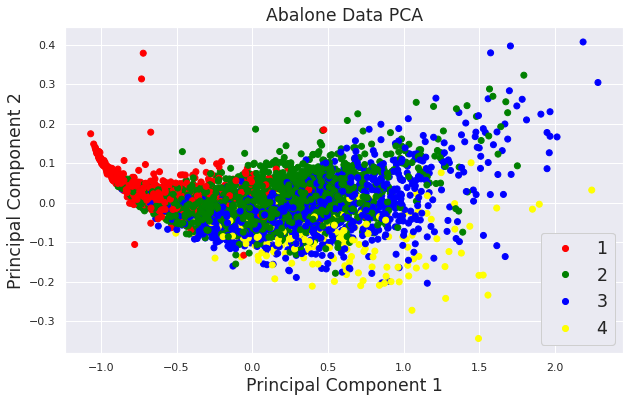

In [5]:
#number of each class
print("Class sizes:",sum(df['AgeClass']==1),sum(df['AgeClass']==2),sum(df['AgeClass']==3),sum(df['AgeClass']==4))

# do a quick PCA (ignore sex)
X = features[:,:7]
X_centered = X - X.mean(axis=0)
pca = PCA(n_components=2) 
X = pca.fit_transform(X_centered)
label = target
colors = ['red','green','blue','yellow']
fig, ax  = plt.subplots()
scatter = ax.scatter(X[:,0], X[:,1], c=label, cmap=matplotlib.colors.ListedColormap(colors))
legend1 = ax.legend(*scatter.legend_elements(),fontsize='x-large')
ax.add_artist(legend1)
plt.title("Abalone Data PCA", fontsize='x-large')
plt.xlabel("Principal Component 1", fontsize='x-large')
plt.ylabel("Principal Component 2", fontsize='x-large')
#ax.grid(True)
plt.savefig('quickPCA.png')
plt.show()


## Standard and custom GridSearch

In [5]:
# do a set of GridSearches for different "cv" values
features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0, test_size=0.40)
depth_range = range(1, 20)
leaf_range = range(1,15)
random_range = range(1,2)
param_grid = dict(max_depth=depth_range, min_samples_leaf=leaf_range,random_state=random_range)
d_tree = tree.DecisionTreeClassifier(class_weight='balanced')
for cv in range(5,15):
    grid = GridSearchCV(d_tree, param_grid, cv=cv ,n_jobs=-1)
    grid.fit(features,target)
    #print(grid.best_score_)
    print(grid.best_params_)
    #print(grid.best_estimator_)
    #print(grid.cv_results_)

{'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 1}
{'max_depth': 18, 'min_samples_leaf': 1, 'random_state': 1}
{'max_depth': 11, 'min_samples_leaf': 1, 'random_state': 1}
{'max_depth': 13, 'min_samples_leaf': 1, 'random_state': 1}
{'max_depth': 7, 'min_samples_leaf': 12, 'random_state': 1}
{'max_depth': 7, 'min_samples_leaf': 8, 'random_state': 1}
{'max_depth': 9, 'min_samples_leaf': 6, 'random_state': 1}
{'max_depth': 7, 'min_samples_leaf': 5, 'random_state': 1}
{'max_depth': 6, 'min_samples_leaf': 9, 'random_state': 1}
{'max_depth': 7, 'min_samples_leaf': 8, 'random_state': 1}


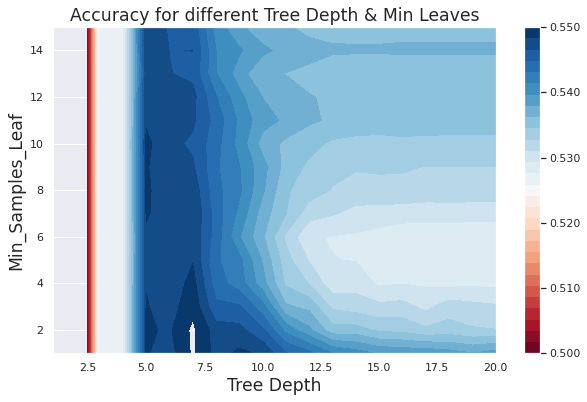

In [6]:
#custom grid-search
import pylab

# Set of hyperparameters to test
XPoints     = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20] #depth
YPoints     = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] #min leaves
ZPoints     = np.ndarray((15,20))

for x in XPoints:
    for y in YPoints:
        ZPoints[y-1][x-1] = short_process_data(y,x)
        
# produce a contour plot of the result the result   
pmin = 0.5 #ZPoints.min().min()
pmax = 0.55 #ZPoints.max().max()

levels = np.linspace(pmin, pmax, 30)
fig, ax = plt.subplots()
ticks = np.linspace(pmin, pmax, 6)

CS = ax.contourf(XPoints, YPoints, ZPoints, cmap="RdBu", levels=levels)
ax.set_aspect('equal')
ax.set_xlabel('Tree Depth')
ax.set_ylabel('Min_Samples_Leaf')
ax.set_title('Accuracy for different Tree Depth & Min Leaves')

fig.colorbar(CS, format="%.3f", ticks=ticks)        
plt.title("Accuracy for different Tree Depth & Min Leaves", fontsize='x-large')
plt.xlabel("Tree Depth", fontsize='x-large')
plt.ylabel("Min_Samples_Leaf", fontsize='x-large')
plt.savefig('customGS.png')

plt.show()


## Decision Tree function

In [6]:
# this function measures the overall accuracy of a tree, as well as the accuracy of each class
def process_data(min_in_leaf):

#    tree_depth = 6
#    min_in_leaf = 1
    class_names=["0-7","8-10","11-15",">15"]
    max_expruns = 100

    # features (x) -> target (y)
    # training is done by clf.fit(features_train, target_train)
    # prediction is done by target_predicted = decision_tree.predict(features_test)
    # so to compare test data, we compare target_test and target_predicted

    perf_trainT = np.zeros(20)  
    perf_testT = np.zeros(20)  
    perf_testT1 = np.zeros(20)  
    perf_testT2 = np.zeros(20)  
    perf_testT3 = np.zeros(20)  
    perf_testT4 = np.zeros(20)  

    for tree_depth in range(1,20):
        perf_train = np.zeros(max_expruns)
        perf_test = np.zeros(max_expruns)  
        perf_test1 = np.zeros(max_expruns)  
        perf_test2 = np.zeros(max_expruns)  
        perf_test3 = np.zeros(max_expruns)  
        perf_test4 = np.zeros(max_expruns)  

        for run_num in range(0,max_expruns):
            # split data into test and train
            features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=run_num,test_size=0.40)
            # define classifier
            clf =  tree.DecisionTreeClassifier(random_state=run_num, min_samples_leaf=min_in_leaf, max_depth=tree_depth,class_weight='balanced')
            # train model
            decision_tree = clf.fit(features_train, target_train)
            # predict both test and train accuracy
            target_test_predicted = decision_tree.predict(features_test) # this is the test.  THIS is the one we want to breakout
            target_train_predicted = decision_tree.predict(features_train) #this is the train
            perf_test[run_num] = accuracy_score(target_test_predicted, target_test)
            perf_train[run_num] = accuracy_score(target_train_predicted, target_train) 

            results_test = np.column_stack((target_test_predicted,target_test))
            results_class1 = results_test[results_test[:,1]==1]
            results_class2 = results_test[results_test[:,1]==2]
            results_class3 = results_test[results_test[:,1]==3]
            results_class4 = results_test[results_test[:,1]==4]

            perf_test1[run_num] = accuracy_score(results_class1[:,0], results_class1[:,1])
            perf_test2[run_num] = accuracy_score(results_class2[:,0], results_class2[:,1])
            perf_test3[run_num] = accuracy_score(results_class3[:,0], results_class3[:,1])
            perf_test4[run_num] = accuracy_score(results_class4[:,0], results_class4[:,1])

        perf_trainT[tree_depth] = np.mean(perf_train)
        perf_testT[tree_depth] = np.mean(perf_test)
        perf_testT1[tree_depth] = np.mean(perf_test1)
        perf_testT2[tree_depth] = np.mean(perf_test2)
        perf_testT3[tree_depth] = np.mean(perf_test3)
        perf_testT4[tree_depth] = np.mean(perf_test4)
    return perf_trainT,perf_testT,perf_testT1, perf_testT2, perf_testT3, perf_testT4


classification score or accuracy score is an improtant metric, however, as rohit mentioned, you would need to report additional details such as the F1 score, precision and recall



## More Exploratory Data Analysis


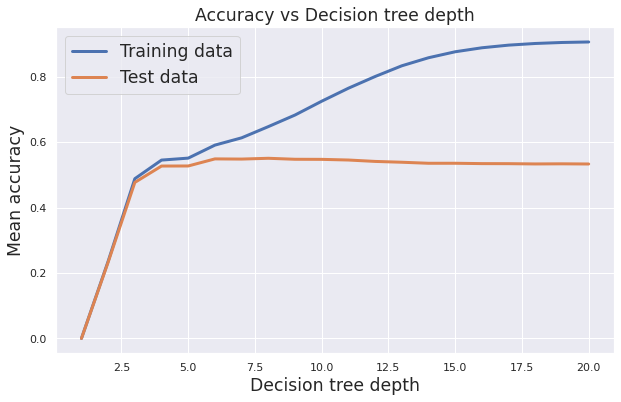

[0.         0.23298025 0.47670856 0.52669659 0.52691203 0.5485398
 0.54799521 0.55040096 0.54737882 0.54712148 0.54510473 0.54082585
 0.53831239 0.5351526  0.53518851 0.53412328 0.53395572 0.53311191
 0.53349491 0.53295631]


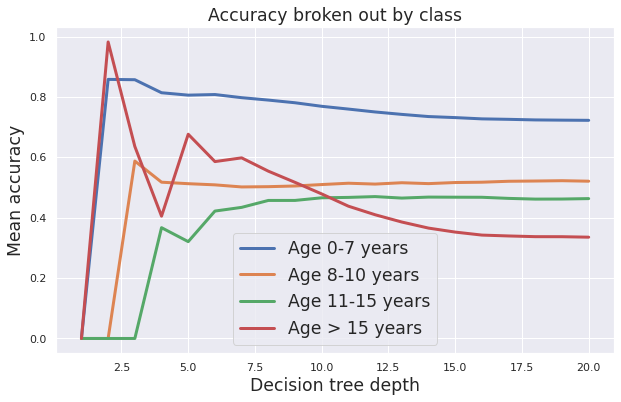

In [8]:
perf_trainT,perf_testT,perf_testT1, perf_testT2, perf_testT3, perf_testT4 = process_data(2)

# plot standard result (additive)
plt.figure(figsize=(10, 6))
plt.plot(range(1,21),perf_trainT,linewidth = '3',label='Training data')
plt.plot(range(1,21),perf_testT,linewidth = '3',label='Test data')
plt.legend(fontsize='x-large')
plt.title("Accuracy vs Decision tree depth", fontsize='x-large')
plt.xlabel("Decision tree depth", fontsize='x-large')
plt.ylabel("Mean accuracy", fontsize='x-large')
plt.savefig('accuracyAllClasses.png')
plt.show()

#print test data result
print(perf_testT)

# plot results by class
plt.figure(figsize=(10, 6))
plt.plot(range(1,21),perf_testT1,linewidth = '3',label='Age 0-7 years')
plt.plot(range(1,21),perf_testT2,linewidth = '3',label='Age 8-10 years')
plt.plot(range(1,21),perf_testT3,linewidth = '3',label='Age 11-15 years')
plt.plot(range(1,21),perf_testT4,linewidth = '3',label='Age > 15 years')
plt.legend(fontsize='x-large')
plt.title("Accuracy broken out by class", fontsize='x-large')
plt.xlabel("Decision tree depth", fontsize='x-large')
plt.ylabel("Mean accuracy", fontsize='x-large')
plt.savefig('accuracyByClass.png')
plt.show()



# Part 1 - Decision tree

Report the Tree Visualisation (show your tree and also translate few selected nodes and leaves into IF and Then rules)

Carry out 10 experiments (minimum of 2 experiments is fine with different random states in train/test split) in Part 1 and 3 and show performance with mean and confidence interval. Note Part 1 may have same results for every experimental run. (Individual submission)

In [55]:
clf =  tree.DecisionTreeClassifier(min_samples_leaf=2,max_depth=8,class_weight='balanced',criterion = 'gini')

# high variance decision tree
print("High variance decision tree")

decision_treeHIGH = clf.fit(features, target)
target_test_predicted = decision_treeHIGH.predict(features)
print("accuracy score:", accuracy_score(target, target_test_predicted))
print(classification_report(target, target_test_predicted,digits=3))
print(decision_treeHIGH.tree_.node_count) #get the node count.
print(decision_treeHIGH.tree_.max_depth)

# low variance decison tree
print()
print("Low variance decision tree")
max_accuracy = 0
max_clf = clf
max_target = 0
max_predicted = 0
max_expruns = 1000
for run_num in range(0,max_expruns):
    features_train, features_test, target_train, target_test = train_test_split(features, 
                                        target,random_state=run_num,test_size=0.80)
    clfGini =  tree.DecisionTreeClassifier(min_samples_leaf=2, max_depth=8,class_weight='balanced',criterion = 'gini')
    clfEntropy =  tree.DecisionTreeClassifier(min_samples_leaf=2, max_depth=8,class_weight='balanced',criterion = 'entropy')
    decision_treeGini = clfGini.fit(features_train, target_train)
    decision_treeEntropy = clfEntropy.fit(features_train, target_train)
    target_test_predictedGini = decision_treeGini.predict(features_test)
    target_test_predictedEntropy = decision_treeEntropy.predict(features_test)
    
    accuracyGini = accuracy_score(target_test, target_test_predictedGini)
    accuracyEntropy = accuracy_score(target_test, target_test_predictedEntropy)

    
    if accuracyGini > max_accuracy:
        max_accuracy = accuracyGini
        max_clf = clfGini
        max_features_train = features_train
        max_features_test = features_test
        max_target_train = target_train 
        max_target_test = target_test
        max_target = target_test
        max_predicted = target_test_predictedGini
        decision_treeLOW = decision_treeGini
        print(max_accuracy,"gini")    
    
    if accuracyEntropy > max_accuracy:
        max_accuracy = accuracyEntropy
        max_clf = clfEntropy
        max_features_train = features_train
        max_features_test = features_test
        max_target_train = target_train 
        max_target_test = target_test
        max_target = target_test
        max_predicted = target_test_predictedEntropy
        max_predicted = target_test_predictedEntropy
        decision_treeLOW = decision_treeEntropy
        print(max_accuracy,"Entropy")
        
print("accuracy score:",max_accuracy)
print(classification_report(max_target_test, max_predicted, digits=3))
print(decision_treeLOW.tree_.node_count) #print the node count.
print(decision_treeLOW.tree_.max_depth) #print the depth

# weighted average accuracy, precision, recall, F1
# weighted average accuracy: balanced_accuracy_score
# standard decision tree


print()
print("Standard decision tree")

stats=np.empty([10,4], dtype=float)
for run_num in range(0,10):
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    decision_treeSTAND = clf.fit(features_train, target_train)
    target_test_predicted = decision_treeSTAND.predict(features_test)
    
    temp=classification_report(target_test,target_test_predicted,output_dict=True)
    stats[run_num,:]=(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
#    print(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
print("mean stats:", np.mean(stats, axis=0))
print("std stats:", np.std(stats, axis=0))
print(classification_report(target_test,target_test_predicted, digits=3))


#plot_tree(decision_tree) 
r = export_text(decision_treeSTAND, show_weights=True, feature_names= list(ff.columns),max_depth=3) 
print(r)


High variance decision tree
accuracy score: 0.6590854680392626
              precision    recall  f1-score   support

           1      0.768     0.880     0.820       839
           2      0.753     0.593     0.663      1891
           3      0.570     0.559     0.564      1186
           4      0.410     0.885     0.560       261

    accuracy                          0.659      4177
   macro avg      0.625     0.729     0.652      4177
weighted avg      0.683     0.659     0.660      4177

343
8

Low variance decision tree
0.49790544584081387 gini
0.5377019748653501 Entropy
0.5595451825254338 gini
0.5742070616397367 gini
0.5769000598444045 gini
0.5867743865948534 gini
accuracy score: 0.5867743865948534
              precision    recall  f1-score   support

           1      0.742     0.727     0.734       662
           2      0.641     0.623     0.632      1523
           3      0.488     0.479     0.483       946
           4      0.274     0.370     0.315       211

    accuracy 

In [18]:
# create confusion matrix
matrix = confusion_matrix(target_test,target_test_predicted)
print(matrix)


[[249  51   9   5]
 [113 386 218  56]
 [ 21 119 232  98]
 [  1   9  40  64]]


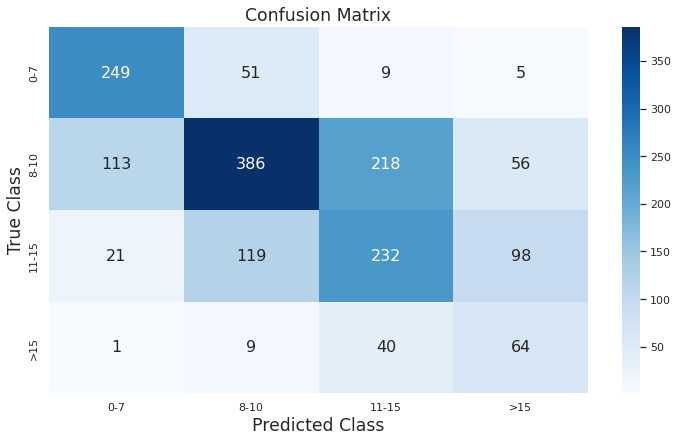

In [19]:
# create pandas dataframe    
class_names=["0-7","8-10","11-15",">15"]
dataframe_Confusion = pd.DataFrame(matrix, index=class_names, columns=class_names)

# create heatmap
sns.heatmap(dataframe_Confusion, annot=True,  cmap="Blues", fmt=".0f",annot_kws={"fontsize":16})
plt.title("Confusion Matrix",fontsize='x-large')
plt.tight_layout()
plt.ylabel("True Class",fontsize='x-large')
plt.xlabel("Predicted Class",fontsize='x-large')
plt.savefig('confusion_matrix.png')
plt.show()
plt.close()


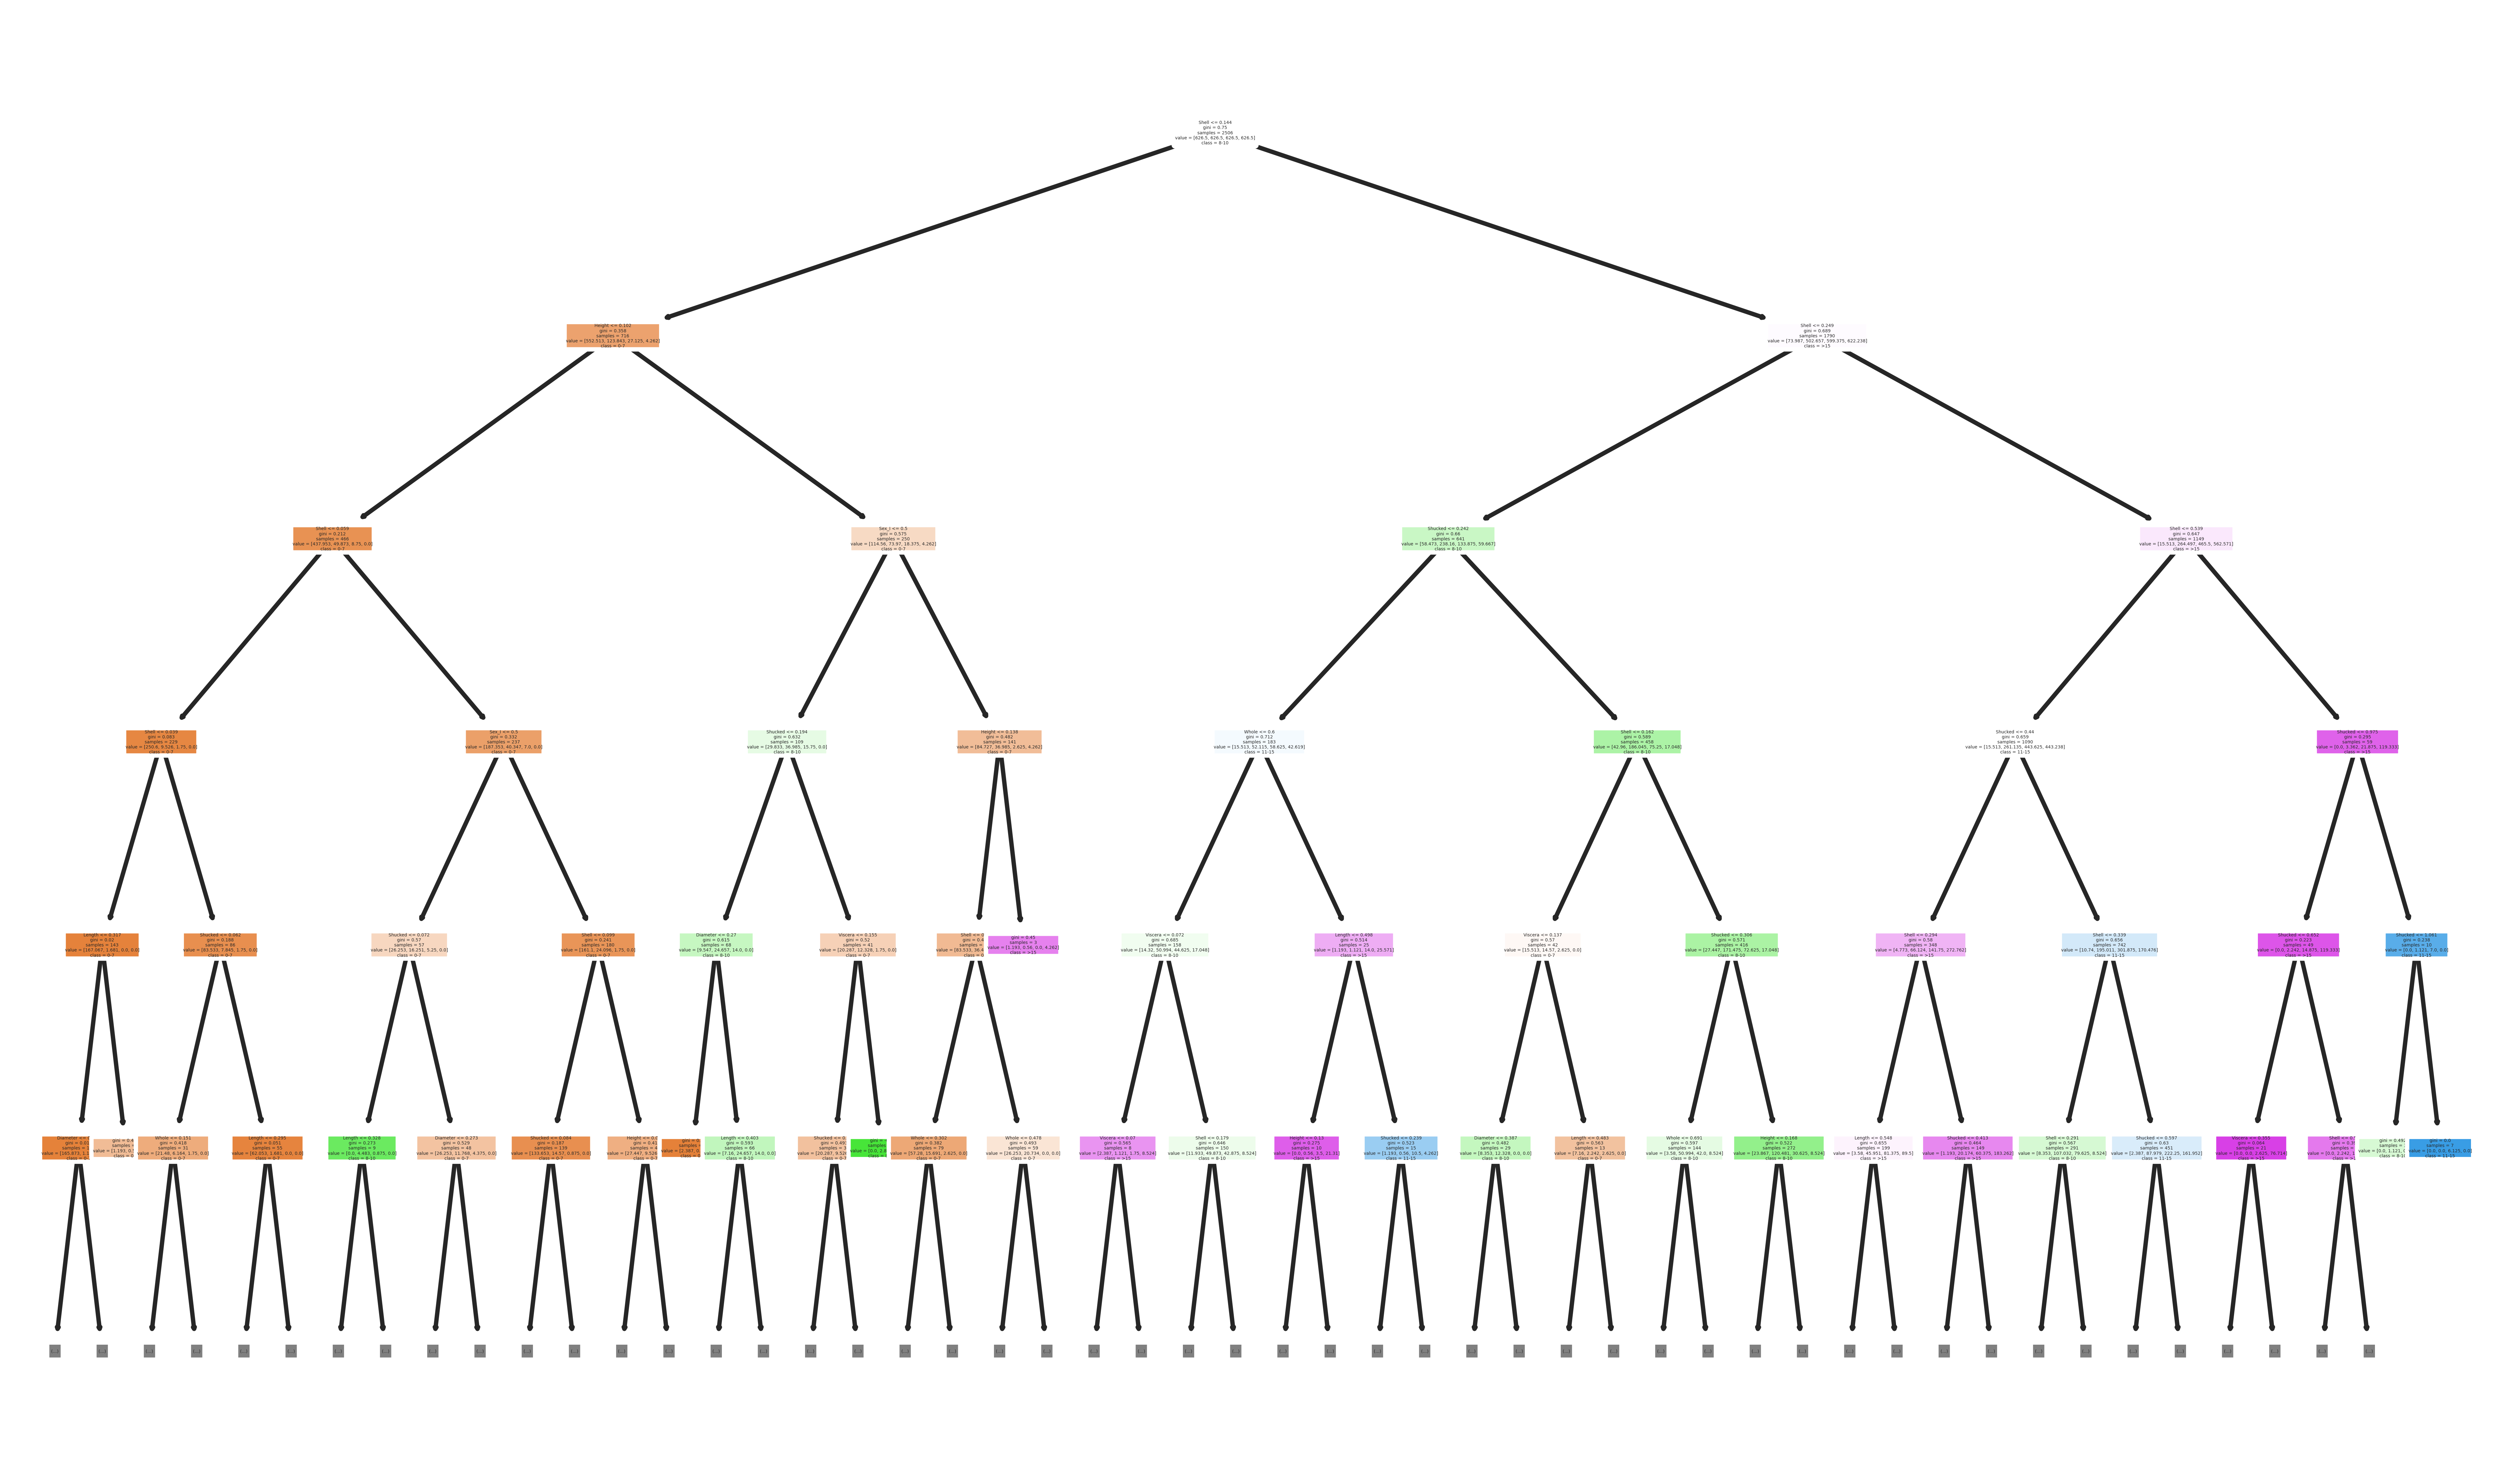

293
8


In [20]:
# plot the standard decision tree to a depth of 5
plt.figure(figsize=(10,6),dpi=1000)
tree.plot_tree(
    decision_treeSTAND,
    rounded=True,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    max_depth=5
    )
plt.savefig('CART_dtree.png')
plt.show()

print(decision_treeSTAND.tree_.node_count) #get the node count.
print(decision_treeSTAND.tree_.max_depth) #get the node count.



# Part 2a - Prepruning

Do an investigation about improving performance further by pruning the tree: https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html (Individual submission)

standard decision tree


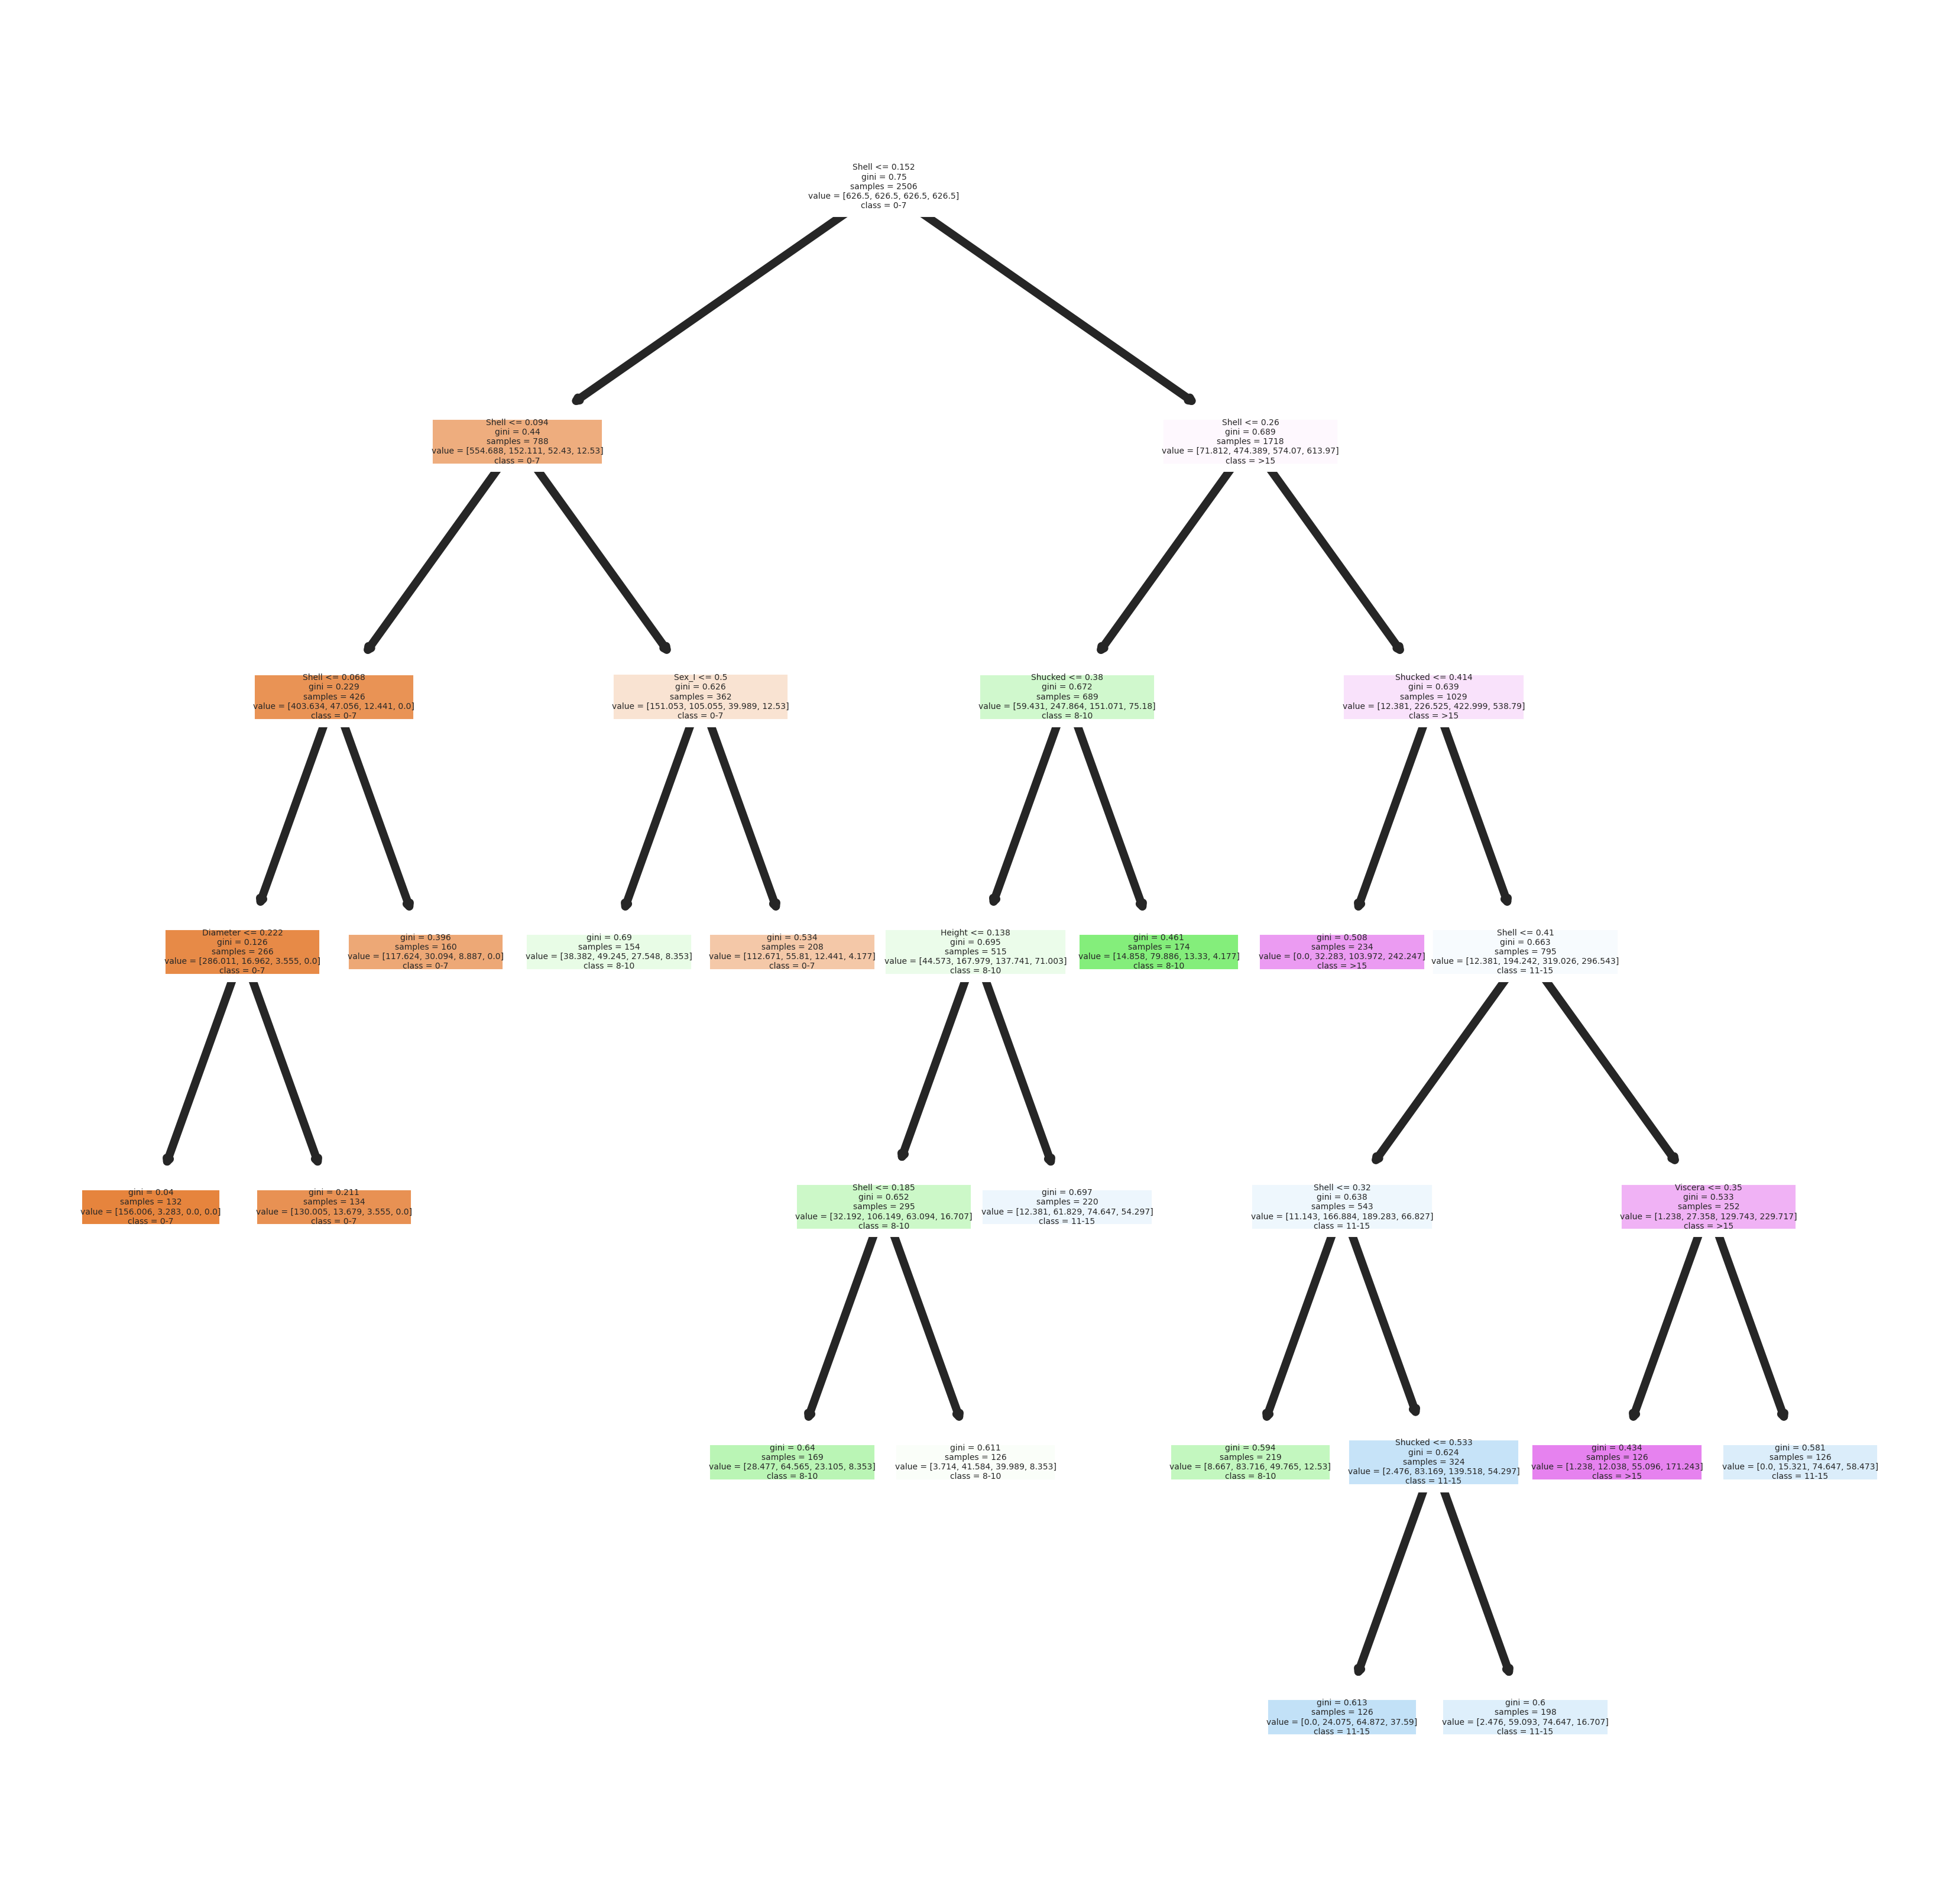

split
              precision    recall  f1-score   support

           1     0.7310    0.8078    0.7675       333
           2     0.6856    0.4853    0.5683       746
           3     0.4764    0.5031    0.4894       481
           4     0.2472    0.5946    0.3492       111

    accuracy                         0.5619      1671
   macro avg     0.5350    0.5977    0.5436      1671
weighted avg     0.6053    0.5619    0.5707      1671

47
8
leaf
              precision    recall  f1-score   support

           1     0.6975    0.8378    0.7613       333
           2     0.6497    0.4799    0.5520       746
           3     0.4785    0.4865    0.4825       481
           4     0.2727    0.5676    0.3684       111

    accuracy                         0.5589      1671
   macro avg     0.5246    0.5929    0.5410      1671
weighted avg     0.5849    0.5589    0.5615      1671

29
6

Max variance decision tree


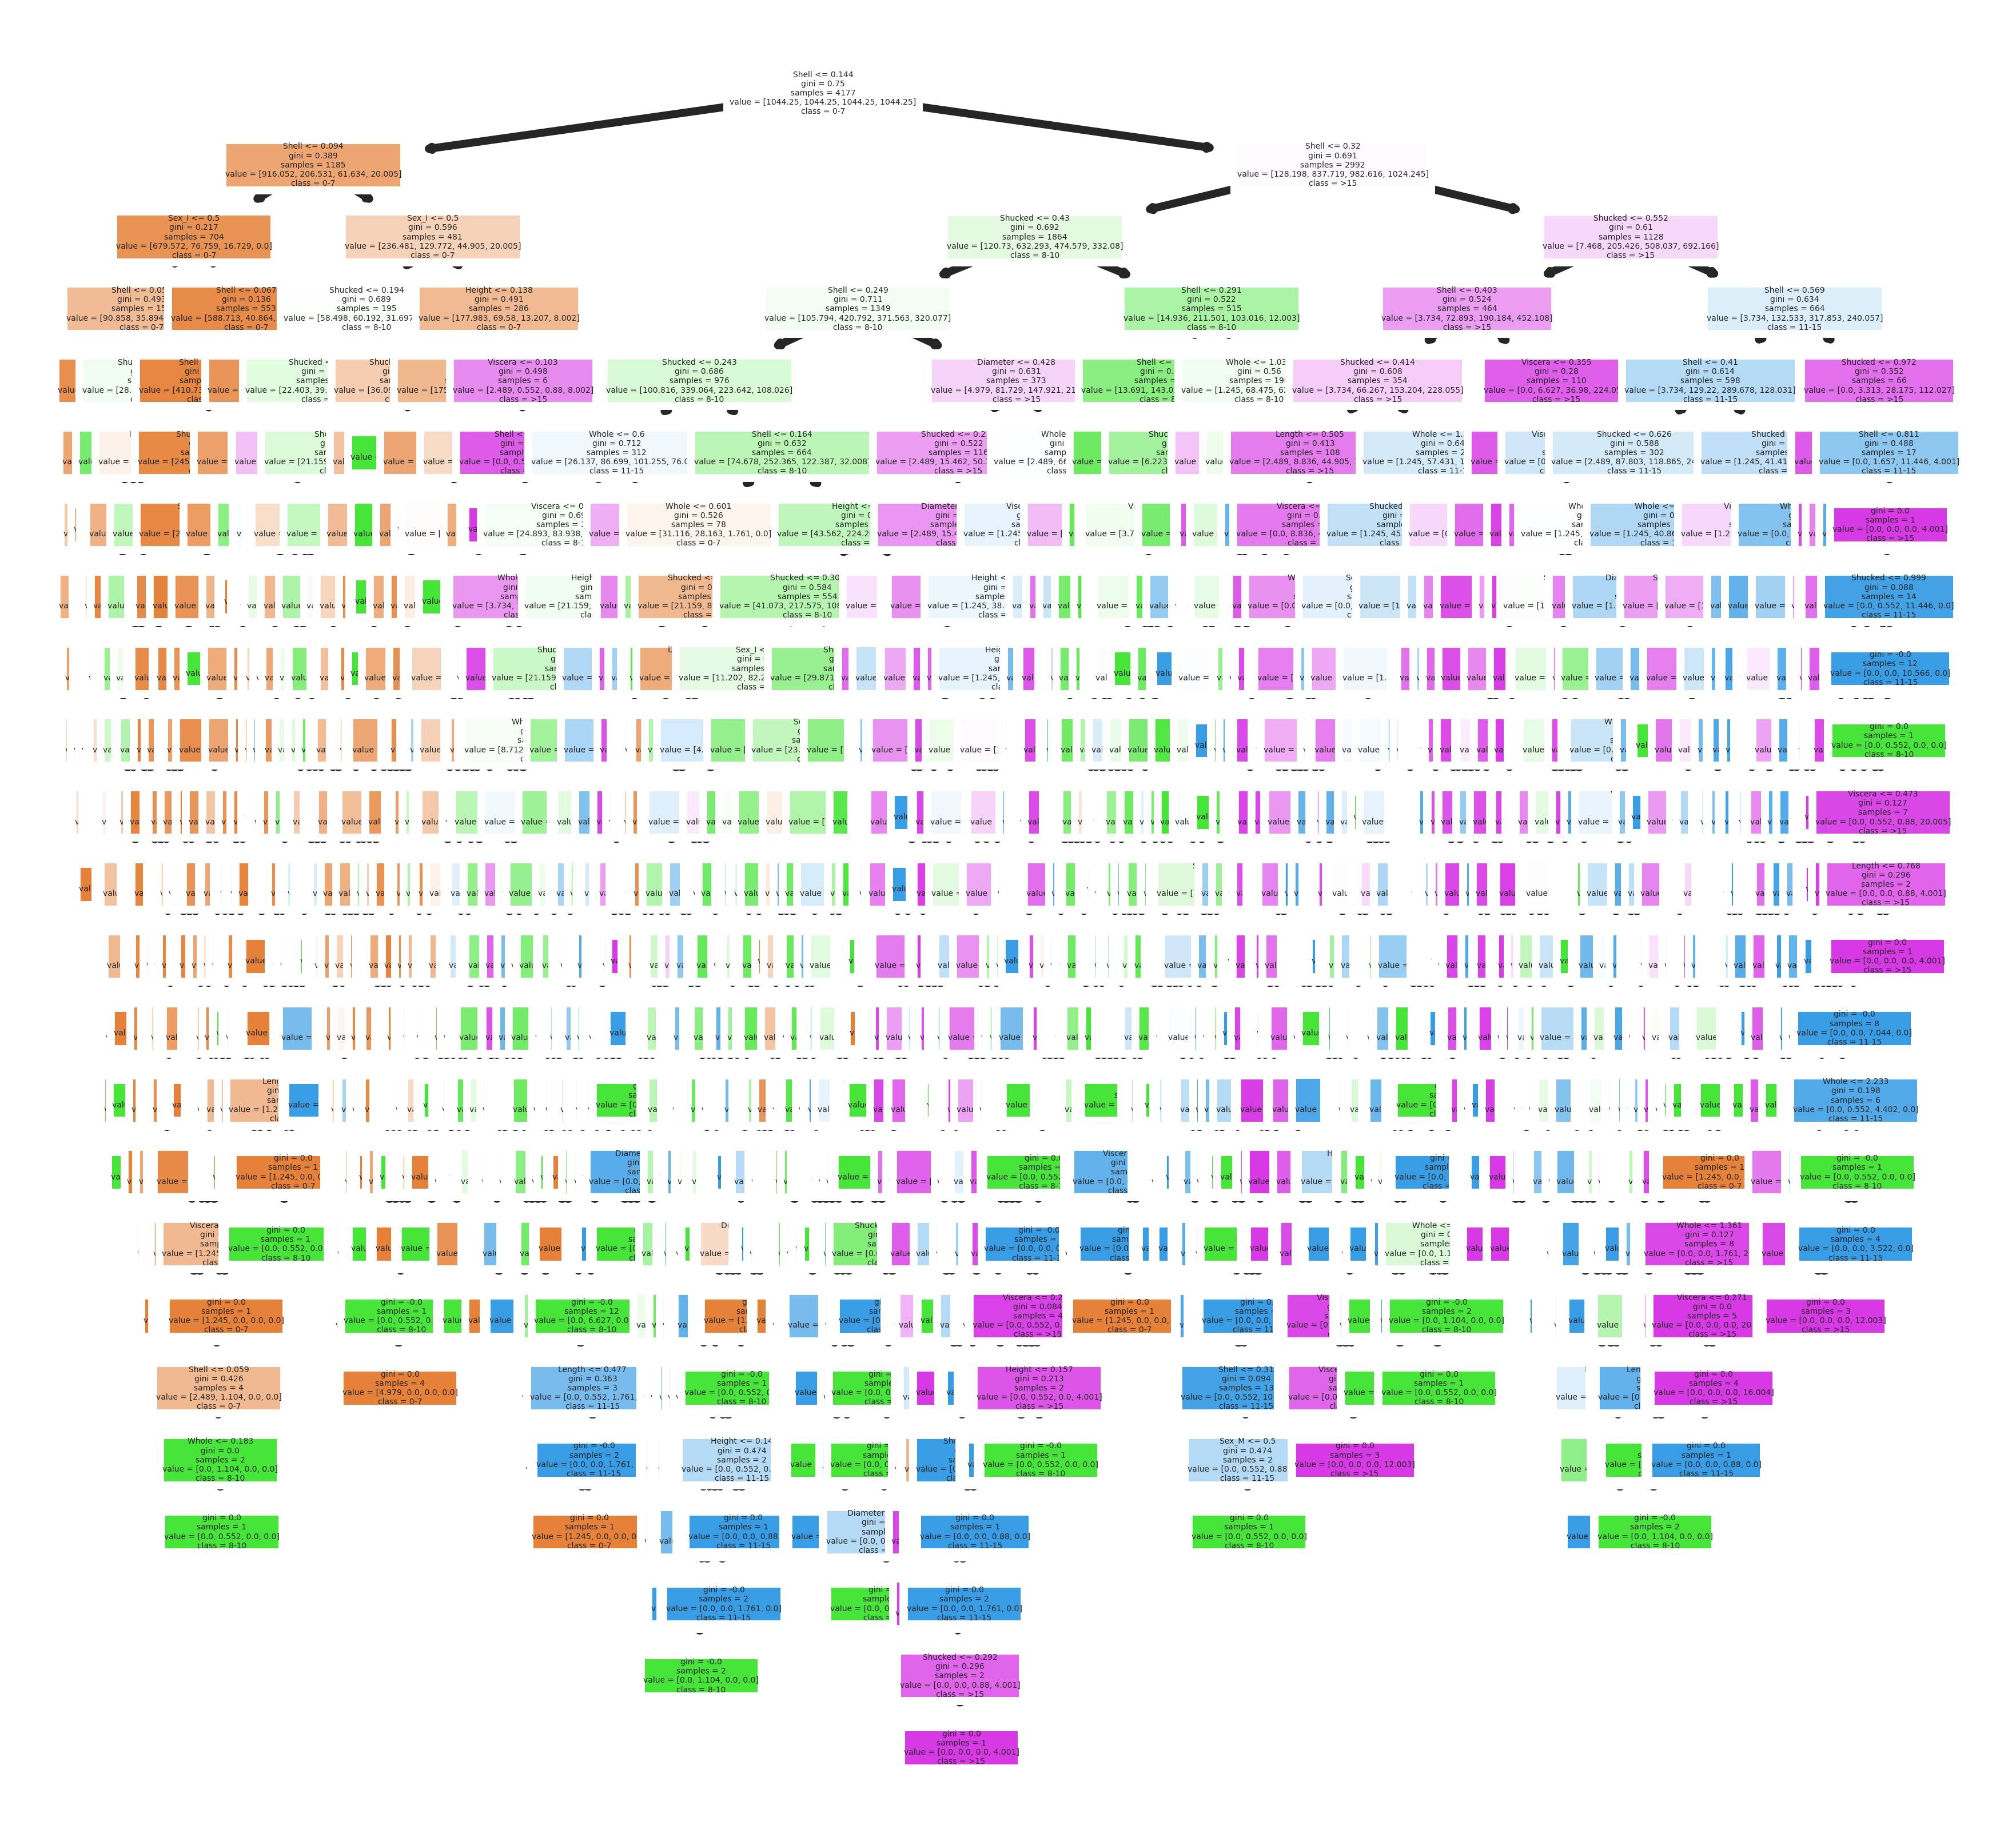

split
              precision    recall  f1-score   support

           1     0.6949    0.8619    0.7694       333
           2     0.6755    0.4464    0.5375       746
           3     0.4757    0.5904    0.5269       481
           4     0.3810    0.5766    0.4588       111

    accuracy                         0.5793      1671
   macro avg     0.5568    0.6188    0.5732      1671
weighted avg     0.6023    0.5793    0.5755      1671

45
9
leaf
              precision    recall  f1-score   support

           1     0.6571    0.8979    0.7589       333
           2     0.6891    0.4249    0.5257       746
           3     0.4663    0.3160    0.3767       481
           4     0.2023    0.7838    0.3216       111

    accuracy                         0.5117      1671
   macro avg     0.5037    0.6057    0.4957      1671
weighted avg     0.5863    0.5117    0.5157      1671

29
6

Min Variance decision tree


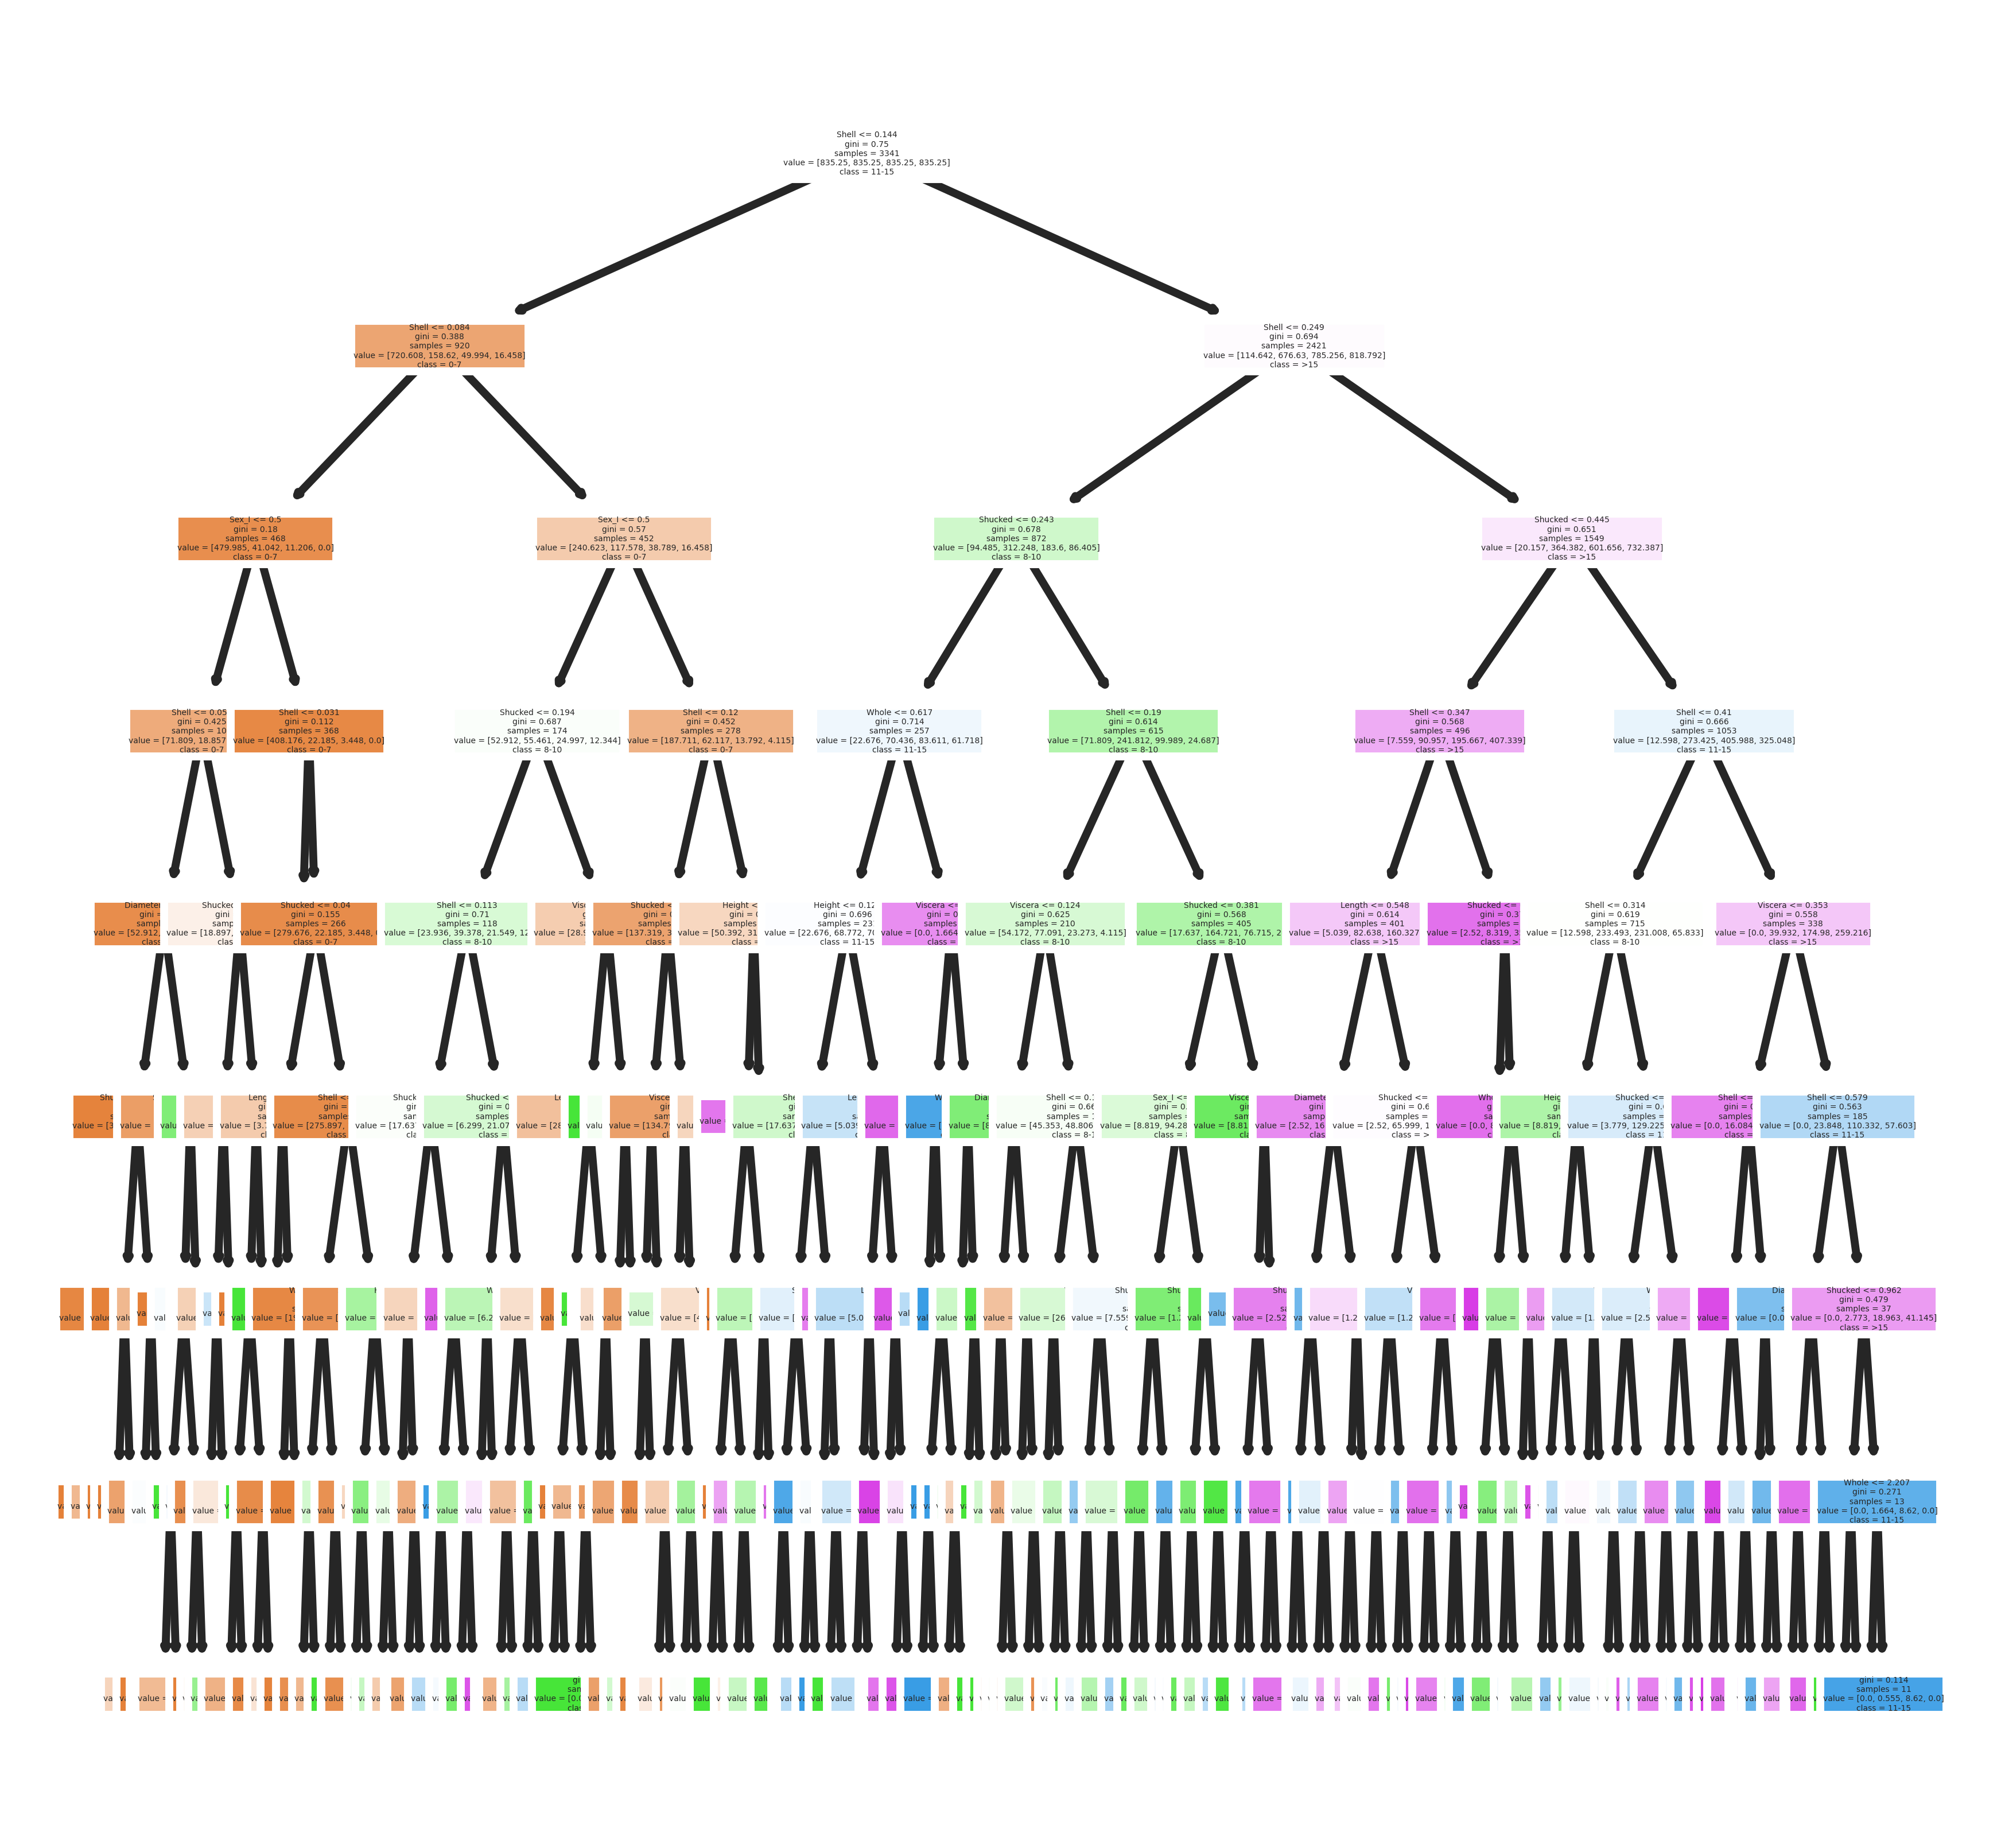

split
              precision    recall  f1-score   support

           1     0.7032    0.8750    0.7797       176
           2     0.7500    0.4286    0.5455       385
           3     0.4221    0.5115    0.4625       217
           4     0.2463    0.5690    0.3438        58

    accuracy                         0.5538       836
   macro avg     0.5304    0.5960    0.5329       836
weighted avg     0.6201    0.5538    0.5593       836

51
7
leaf
              precision    recall  f1-score   support

           1     0.6653    0.9148    0.7703       176
           2     0.7540    0.4935    0.5965       385
           3     0.4626    0.4562    0.4594       217
           4     0.2578    0.5690    0.3548        58

    accuracy                         0.5778       836
   macro avg     0.5349    0.6084    0.5453       836
weighted avg     0.6253    0.5778    0.5808       836

67
8


In [28]:
# Standard variance
clf =  tree.DecisionTreeClassifier(class_weight='balanced',criterion = 'gini',random_state=0)
print("standard decision tree")
#clf = decision_treeSTAND
min_samples_split_grid_search = GridSearchCV(
    estimator = clf,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_split": [[min_samples_split] for min_samples_split in np.arange(0.025,1,0.025)]}),)

min_samples_leaf_grid_search = GridSearchCV(
    estimator = clf,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_leaf": [[min_samples_leaf] for min_samples_leaf in np.arange(0.025,0.5,0.025)]}),)

min_samples_split_grid_search.fit(features_train,target_train)
min_samples_leaf_grid_search.fit(features_train,target_train)

min_samples_split_grid_search.best_params_
min_samples_leaf_grid_search.best_params_

best_min_samples_split_tree = min_samples_split_grid_search.best_estimator_
best_min_samples_leaf_tree = min_samples_leaf_grid_search.best_estimator_

plt.figure(figsize=(4,4),dpi=1000)
class_names=["0-7","8-10","11-15",">15"]

tree.plot_tree(
    best_min_samples_leaf_tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True)
plt.savefig('CART_dtree_2A.png')
plt.show()

print("split")
print(classification_report(target_test, best_min_samples_split_tree.predict(features_test),digits=4))
print(best_min_samples_split_tree.tree_.node_count) #get the node count.
print(best_min_samples_split_tree.tree_.max_depth) #get the node count.

print("leaf")
print(classification_report(target_test, best_min_samples_leaf_tree.predict(features_test),digits=4))
print(best_min_samples_leaf_tree.tree_.node_count) #get the node count.
print(best_min_samples_leaf_tree.tree_.max_depth) #get the node count.

# Max variance
print()
print("Max variance decision tree")
decision_treeHIGH = clf.fit(features, target)

min_samples_split_grid_search = GridSearchCV(
    estimator = decision_treeHIGH,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_split": [[min_samples_split] for min_samples_split in np.arange(0.025,1,0.025)]}),)

min_samples_leaf_grid_search = GridSearchCV(
    estimator = decision_treeHIGH,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_leaf": [[min_samples_leaf] for min_samples_leaf in np.arange(0.025,0.5,0.025)]}),)

min_samples_split_grid_search.fit(features, target)
min_samples_leaf_grid_search.fit(features, target)

min_samples_split_grid_search.best_params_
min_samples_leaf_grid_search.best_params_

best_min_samples_split_tree = min_samples_split_grid_search.best_estimator_
best_min_samples_leaf_tree = min_samples_leaf_grid_search.best_estimator_

plt.figure(figsize=(4,4),dpi=1000)
tree.plot_tree(
    decision_treeHIGH,
    feature_names=feature_names,
    class_names=class_names,
    filled=True)
plt.show()

print("split")
print(classification_report(target_test, best_min_samples_split_tree.predict(features_test),digits=4))
print(best_min_samples_split_tree.tree_.node_count) #get the node count.
print(best_min_samples_split_tree.tree_.max_depth) #get the node count.

print("leaf")
print(classification_report(target_test, best_min_samples_leaf_tree.predict(features_test),digits=4))
print(best_min_samples_leaf_tree.tree_.node_count) #get the node count.
print(best_min_samples_leaf_tree.tree_.max_depth) #get the node count.

# Min variance
print("")
print("Min Variance decision tree")
#        max_accuracy = accuracyEntropy
#        max_clf = clfEntropy
#        max_features_train = features_train
#        max_features_test = features_test
#        max_target_train = target_train 
#        max_target_test = target_test
#        max_target = target_test
#        max_predicted = target_test_predictedGini
#        max_predicted = target_test_predictedEntropy
#        decision_treeLOW = decision_treeEntropy
#        print(max_accuracy,"Entropy")

min_samples_split_grid_search = GridSearchCV(
    estimator = max_clf,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_split": [[min_samples_split] for min_samples_split in np.arange(0.025,1,0.025)]}),)

min_samples_leaf_grid_search = GridSearchCV(
    estimator = max_clf,
    scoring = make_scorer(accuracy_score),
    param_grid = ParameterGrid({"min_samples_leaf": [[min_samples_leaf] for min_samples_leaf in np.arange(0.025,0.5,0.025)]}),)

min_samples_split_grid_search.fit(max_features_train,max_target_train)
min_samples_leaf_grid_search.fit(max_features_train,max_target_train)

min_samples_split_grid_search.best_params_
min_samples_leaf_grid_search.best_params_

best_min_samples_split_tree = min_samples_split_grid_search.best_estimator_
best_min_samples_leaf_tree = min_samples_leaf_grid_search.best_estimator_

plt.figure(figsize=(4,4),dpi=1000)
class_names=["0-7","8-10","11-15",">15"]

tree.plot_tree(
    max_clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True)
plt.show()

print("split")
print(classification_report(max_target_test, best_min_samples_split_tree.predict(max_features_test),digits=4))
print(best_min_samples_split_tree.tree_.node_count) #get the node count.
print(best_min_samples_split_tree.tree_.max_depth) #get the node count.

print("leaf")
print(classification_report(max_target_test, best_min_samples_leaf_tree.predict(max_features_test),digits=4))
print(best_min_samples_leaf_tree.tree_.node_count) #get the node count.
print(best_min_samples_leaf_tree.tree_.max_depth) #get the node count.

## Part 2b - PostPruning

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


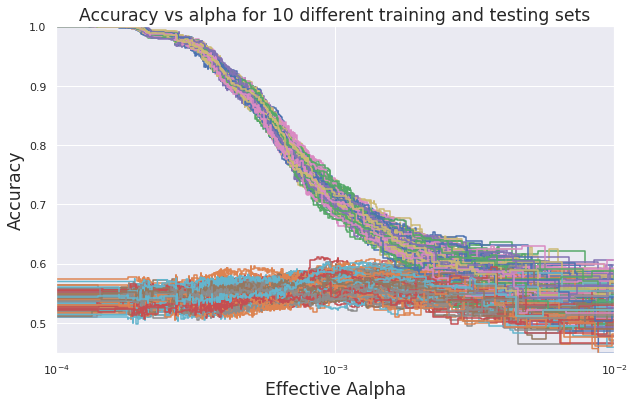

[0.0016486332137942942, 0.006810453699461101, 0.0015123445616719003, 0.0021674014604661485, 0.0019218907430953993, 0.0021867618093161303, 0.0007034382732661516, 0.0015789100481376876, 0.0023384032125394263, 0.0028575232666414275, 0.0012985519312189078, 0.002184962411603956, 0.0009465112303146091, 0.0020097108498204966, 0.000875888150935945, 0.0012393840188987858, 0.002920788269892109, 0.003412281640213514, 0.0009515630691735591, 0.0008656421685163988, 0.0008366711406724734, 0.00200210146287815, 0.001178774092094017, 0.0006760625063875748, 0.0049935476990323815, 0.001658777344795104, 0.0008710785830199139, 0.001327602215431132, 0.0027170448247532918, 0.0007650931688380852, 0.00041573127130622973, 0.013422936535419316, 0.0010010135205368075, 0.0026305074840400275, 0.0009328588492084882, 0.0006729203458092184, 0.0008851939797114707, 0.0009816837727421098, 0.0009104098193689373, 0.0009675857390785255, 0.0006318207926479109, 0.0007471915081908255, 0.0010036636292452196, 0.001689152437678379

In [25]:
## explore the effective alpha for post-pruning

# setup the figure for plotting multiple accuracy vs alpha curves
fig, ax = plt.subplots()
ax.set_xlabel("Effective Aalpha", fontsize='x-large')
ax.set_ylabel("Accuracy", fontsize='x-large')
ax.set_title("Accuracy vs alpha for 10 different training and testing sets",fontsize='x-large')

#ax.grid(True)

# initialize variable 
cum_alpha, cum_acc =[],[]  # accumulative every alpha and accumulative every resultant accuracy for post-pruning curves
max_alpha, max_acc = [],[] # the maximum accuracy for any post-pruning curve and corresponding accuracy.
stats=np.empty([10,4], dtype=float)

# undertake a large number of post-pruning decision trees
for run_num in range(0,200):
#    print(run_num)
    clf =  tree.DecisionTreeClassifier(class_weight='balanced',criterion = 'gini')
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    clf = clf.fit(features_train, target_train)
    path = clf.cost_complexity_pruning_path(features_train, target_train)
    alphas=path['ccp_alphas']
    accuracy_train,accuracy_test = [],[]
    mAccuracy = 0
    for i in alphas:
        treeX=DecisionTreeClassifier(ccp_alpha=i,class_weight='balanced',or
                                     criterion = 'gini')
        treeX.fit(features_train, target_train)
        target_train_pred = treeX.predict(features_train)
        target_test_pred=treeX.predict(features_test)
        accuracy_train.append(accuracy_score(target_train,target_train_pred))
        accuracy_test.append(accuracy_score(target_test,target_test_pred))
        cum_alpha.append(i)
        cum_acc.append(accuracy_score(target_test,target_test_pred))
        if accuracy_test[-1] > mAccuracy:
            mAccuracy = accuracy_test[-1]
            mAlpha=i
    max_alpha.append(mAlpha)
    max_acc.append(mAccuracy)
    ax.plot(alphas, accuracy_train, drawstyle="steps-post")
    ax.plot(alphas, accuracy_test, drawstyle="steps-post")
#ax.legend()
ax.set_xscale('log')
ax.set_xlim([0.0001, 0.01])
ax.set_ylim([0.45, 1.0])
plt.savefig('multipleAlphaCurves.png')
plt.show()
print(max_alpha)
print(max_acc)


[0.56235298 0.56234182 0.56232946 0.56231591 0.56230118 0.56228527
 0.56226819 0.56224994 0.56223052 0.56220995 0.56218823 0.56216536
 0.56214135 0.5621162  0.56208992 0.56206252 0.56203399 0.56200436
 0.56197362 0.56194177 0.56190883 0.56187481 0.5618397  0.56180351
 0.56176626]
0.0012777396472683459 0.5620043589430423


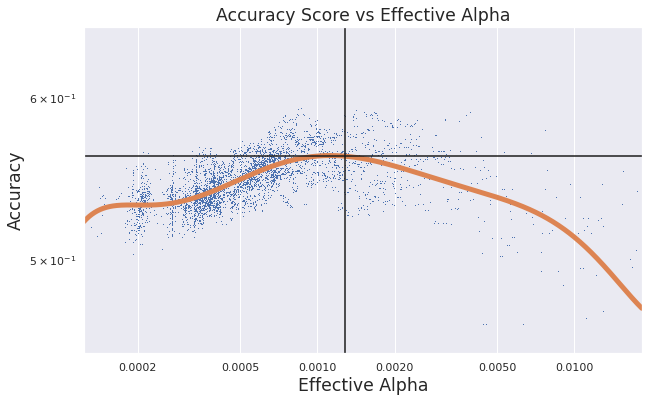

In [24]:
# searches for the optimal effective alpha

temp1=np.array(cum_alpha)
temp2=np.array(cum_acc)
temp=np.vstack((temp1, temp2)).T
temp3 = np.delete(temp, np.where((temp[:, 0] < 0.0000001))[0], axis=0)
temp3 = np.delete(temp3, np.where((temp3[:, 0] > 0.02))[0], axis=0)

# fit a polynomial to the data
coefficients = np.polyfit(np.log(temp3[:,0]),temp3[:,1], 7)
poly = np.poly1d(coefficients)
new_x = np.linspace(-9, -4,num=1000)
new_y = poly(new_x)

xpos = new_x[467]
ypos = new_y[467]
print(new_y[450:475])

#plot the effective alpha graph
fig, ax = plt.subplots()
plt.semilogx(temp3[:,0],temp3[:,1],marker=',',linestyle = 'None')
plt.semilogy(np.exp(new_x),new_y,linewidth=5)

ax.set_xscale('log')
ax.set_xticks([0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

#ax.set_xticks([20, 200, 500])
ax.set_xlim(np.exp(-9),np.exp(-4))
ax.set_ylim(0.45,0.65)

plt.axvline(x=np.exp(xpos),color='k')
plt.axhline(y=ypos,color='k')
print(np.exp(xpos),ypos)
plt.title("Accuracy Score vs Effective Alpha", fontsize='x-large')
plt.xlabel("Effective Alpha", fontsize='x-large')
plt.ylabel("Accuracy", fontsize='x-large')
#ax.grid(True)
plt.savefig('findAlpha.png')
plt.show()


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

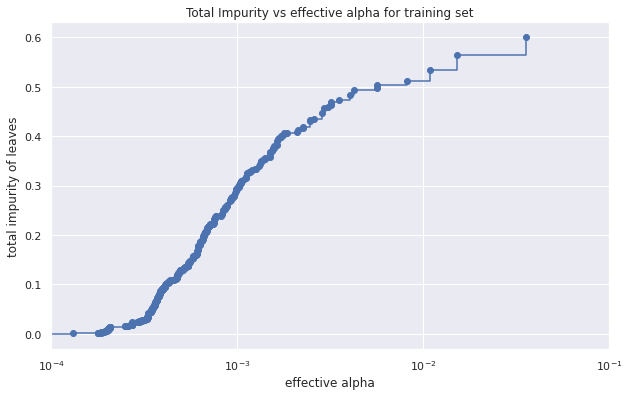

In [214]:
# explore other notions about effective alpha
print(np.exp(np.mean(np.log(max_alpha))),np.exp(np.mean(np.log(max_alpha))))
print(np.mean(max_alpha),np.std(max_alpha))
print(np.median(max_alpha))
print(decision_treeSTAND.tree_.node_count) #get the node count.
print(decision_treeSTAND.tree_.max_depth) #get the node count.
from scipy import stats
print(stats.describe(np.log(max_alpha)))

plt.hist(np.log(max_alpha),bins=25)
print("alpa",np.exp(-7))

In [32]:
#compute the statistics for the decision tree, given an optimal alpha

accuracy_test = []
for run_num in range(0,10):
    clf =  tree.DecisionTreeClassifier(ccp_alpha=0.00128,
                                       class_weight='balanced',criterion = 'gini')
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    clf = clf.fit(features_train, target_train)
    target_test_predicted = clf.predict(features_test)

    accuracy_test.append(accuracy_score(target_test,target_test_predicted))
print(np.mean(accuracy_test), np.std(accuracy_test))
#stats.describe(accuracy_test)



0.5573907839616996 0.015749883087584435


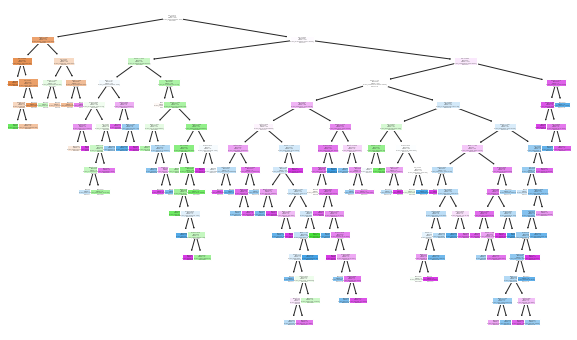

179
14
              precision    recall  f1-score   support

           1      0.613     0.882     0.723       314
           2      0.696     0.515     0.592       773
           3      0.468     0.432     0.449       470
           4      0.239     0.447     0.312       114

    accuracy                          0.556      1671
   macro avg      0.504     0.569     0.519      1671
weighted avg      0.585     0.556     0.557      1671



In [39]:
# plot the post-pruned tree
tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True)
plt.savefig('CART_dtree_2B.png')
plt.show()


print(clf.tree_.node_count) #get the node count.
print(clf.tree_.max_depth) #get the node count.
print(classification_report(target_test,target_test_predicted,digits=3))


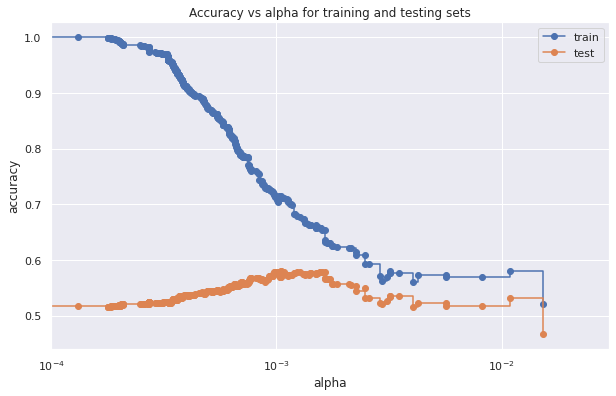

In [151]:
#plot a single training & test set for alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,class_weight='balanced')
    clf.fit(features_train, target_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

In [ ]:
train_scores = [clf.score(features_train, target_train) for clf in clfs]
test_scores = [clf.score(features_test, target_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
ax.set_xscale('log')
ax.set_xlim([0.0001, 0.03])
plt.show()

1


# Part 3 - Bagging

Apply Bagging of Trees via Random Forests and show performance as your number of trees in the ensembles increases. 

Carry out 10 experiments (minimum of 2 experiments is fine with different random states in train/test split) in Part 1 and 3 and show performance with mean and confidence interval. Note Part 1 may have same results for every experimental run. (Individual submission)


In [15]:
# compute the bagging and pasting statistics
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

def bagPaste(n_estimators,max_samples,random_state):
    features_train, features_test, target_train, target_test = train_test_split(features, 
                target, random_state=random_state,test_size=0.40)    
    bag_clf = BaggingClassifier(
        DecisionTreeClassifier(class_weight='balanced'), 
        n_estimators=n_estimators,
        max_samples=max_samples, 
        bootstrap=True, 
        n_jobs=-1)
    bag_clf.fit(features_train, target_train.ravel())
    bag_pred = bag_clf.predict(features_test)
    bag_acc = accuracy_score(target_test,bag_pred)
    
    paste_clf = BaggingClassifier(
        DecisionTreeClassifier(class_weight='balanced'), 
        n_estimators=n_estimators,
        max_samples=max_samples, 
        bootstrap=False, 
        n_jobs=-1)
    paste_clf.fit(features_train, target_train.ravel())
    paste_pred = paste_clf.predict(features_test)
    paste_acc = accuracy_score(target_test,paste_pred)
    
    return bag_acc,paste_acc



a=[2**n for n in range(1, 11)]
bag_mean, bag_std =[],[]
paste_mean, paste_std =[],[]
for n_estimators in a:
    print(n_estimators)
    bag_acc=[]
    paste_acc=[]
    for run_num in range(1,100):
        Tbag, Tpaste = bagPaste(n_estimators,200,run_num)
        bag_acc.append(Tbag)
        paste_acc.append(Tpaste)
    bag_mean.append(np.mean(bag_acc))
    bag_std.append(np.std(bag_acc))
    paste_mean.append(np.mean(paste_acc))
    paste_std.append(np.std(paste_acc))
    
#    paste_mean.append(np.mean(paste_acc))
#    paste_std.append(np.std(paste_acc))



2
4
8
16
32
64
128
256
512
1024


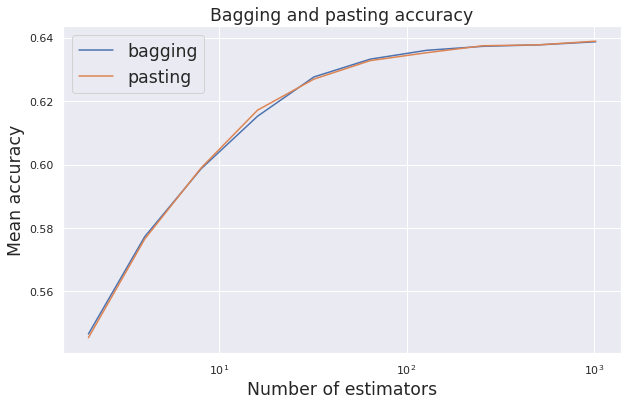

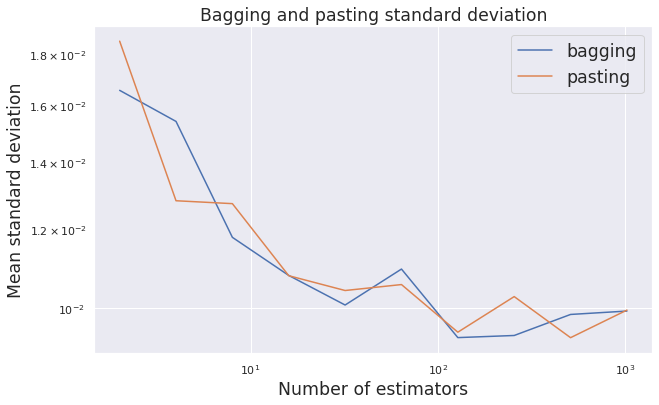

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] [0.5465849397626777, 0.5772869327626957, 0.5986797961663313, 0.6152186134232813, 0.6275985468086007, 0.6332142490131719, 0.6360009430027384, 0.6372582799871848, 0.6377297813563524, 0.638690918762732] [0.016553818835408976, 0.015404468006969147, 0.011778100426771005, 0.01078389284580881, 0.01006973699641661, 0.010944071418174285, 0.009337963028101911, 0.009383919252412136, 0.009852298096732581, 0.009929845362255375]


In [19]:
#plot the bagging and pasting results
plt.semilogx(a,bag_mean,label="bagging")
plt.semilogx(a,paste_mean,label="pasting")
plt.title("Bagging and pasting accuracy", fontsize='x-large')
plt.xlabel("Number of estimators", fontsize='x-large')
plt.ylabel("Mean accuracy", fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig('bagpasteAccuracy.png')
plt.show()

              
plt.loglog(a,bag_std,label="bagging")
plt.loglog(a,paste_std,label = "pasting")
plt.title("Bagging and pasting standard deviation", fontsize='x-large')
plt.xlabel("Number of estimators", fontsize='x-large')
plt.ylabel("Mean standard deviation", fontsize='x-large')
plt.legend(fontsize='x-large')
plt.savefig('bagpasteSTD.png')
plt.show()


print(a, bag_mean, bag_std) 


In [30]:
#compute the mean and standard deviation of either bagging

stats=np.empty([10,4], dtype=float)
for run_num in range(0,10):
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=512,max_samples=100, bootstrap=False, n_jobs=-1)
    bag_clf.fit(features_train, target_train.ravel())
    target_test_predicted = bag_clf.predict(features_test)
    temp=classification_report(target_test,target_test_predicted,output_dict=True)
    stats[run_num,:]=(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
#    print(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
print("mean stats:", np.mean(stats, axis=0))
print("std stats:", np.std(stats, axis=0))
print(classification_report(target_test,target_test_predicted, digits=3))

#    bag_clf = BaggingClassifier(
#        DecisionTreeClassifier(class_weight='balanced'), 
#        n_estimators=n_estimators,
#        max_samples=max_samples, 
#        bootstrap=True, 
#        n_jobs=-1)
#    bag_clf.fit(features_train, target_train.ravel())
#    bag_pred = bag_clf.predict(features_test)
#    bag_acc = accuracy_score(target_test,bag_pred)



mean stats: [0.6320766  0.63382617 0.6320766  0.61177964]
std stats: [0.01083101 0.01445281 0.01083101 0.01275108]
              precision    recall  f1-score   support

           1      0.740     0.726     0.733       314
           2      0.648     0.770     0.704       773
           3      0.535     0.500     0.517       470
           4      0.667     0.035     0.067       114

    accuracy                          0.636      1671
   macro avg      0.648     0.508     0.505      1671
weighted avg      0.635     0.636     0.613      1671



In [59]:
#compute the mean and standard deviation of either pasting
stats=np.empty([10,4], dtype=float)
for run_num in range(0,10):
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    bag_clf = BaggingClassifier(DecisionTreeClassifier(class_weight='balanced'), n_estimators=512,max_samples=100, bootstrap=True, n_jobs=-1)
    bag_clf.fit(features_train, target_train.ravel())
    target_test_predicted = bag_clf.predict(features_test)
    temp=classification_report(target_test,target_test_predicted,output_dict=True)
    stats[run_num,:]=(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
#    print(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
print("mean stats:", np.mean(stats, axis=0))
print("std stats:", np.std(stats, axis=0))
print(classification_report(target_test,target_test_predicted, digits=3))

#    bag_clf = BaggingClassifier(
#        DecisionTreeClassifier(class_weight='balanced'), 
#        n_estimators=n_estimators,
#        max_samples=max_samples, 
#        bootstrap=True, 
#        n_jobs=-1)
#    bag_clf.fit(features_train, target_train.ravel())
#    bag_pred = bag_clf.predict(features_test)
#    bag_acc = accuracy_score(target_test,bag_pred)



mean stats: [0.63016158 0.62960944 0.63016158 0.60899922]
std stats: [0.00879937 0.01123327 0.00879937 0.01036009]
              precision    recall  f1-score   support

           1      0.733     0.752     0.742       314
           2      0.648     0.757     0.698       773
           3      0.531     0.498     0.514       470
           4      0.800     0.035     0.067       114

    accuracy                          0.634      1671
   macro avg      0.678     0.510     0.505      1671
weighted avg      0.641     0.634     0.611      1671



ValueError: x and y must have same first dimension, but have shapes (11,) and (99,)

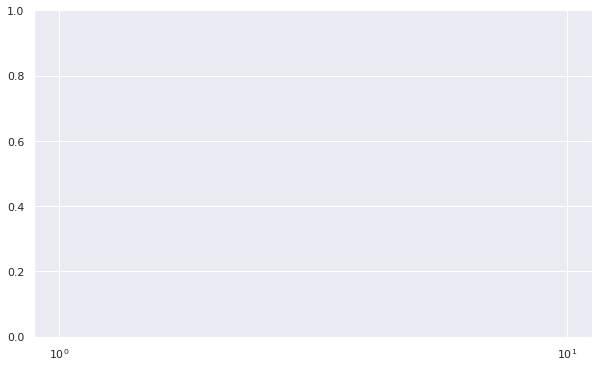

In [51]:
# search for the optimal postpruning max_samples
bag, paste = [],[]
a=[2**n for n in range(1, 12)]
for max_samples in a:
    for repeat in range(1,10):
        Tbag, Tpaste = bagPaste(max_samples,200,0)
        bag.append(Tbag)
        paste.append(Tpaste)
#plt.semilogx(a,bag,color='blue')
#plt.semilogx(a,paste,color='red')
#plt.legend(fontsize='x-large')
#plt.show()
#plt.semilogx(a,acc_mean)

# Part 4
Compare results with Adam and SGD (Neural Networks) and discuss them. (Individual submission)

In [44]:
# this is the neural network code from the course - it was not used for the report.

import numpy as np 

import matplotlib.pyplot as plt
from numpy import *

from sklearn import datasets 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import random
from sklearn.metrics import roc_curve, auc


    
def scipy_nn(x_train, x_test, y_train, y_test, type_model, hidden, learn_rate, run_num):
    #Source: https://scikit-learn.org/stable/modules/neural_networks_supervised.html

    #random_stateint, RandomState instance, default=None Determines random number generation
    # for weights and bias initialization, train-test split if early stopping is used, and batch sampling when solver=’sgd’
    #or ‘adam’. Pass an int for reproducible results across multiple function calls.

    #learning_rate_initdouble, default=0.001
    #The initial learning rate used. It controls the step-size in updating the weights. Only used when solver=’sgd’ or ‘adam’.

    #note Adam does not need momentum and constant learning rate since they are adjusted in Adam itself

    if type_model ==0: #SGD
        nn = MLPClassifier(hidden_layer_sizes=(hidden,), random_state=run_num, max_iter=5000,solver='sgd',  
                           learning_rate_init=learn_rate )
        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    elif type_model ==1: #Adam
        nn = MLPClassifier(hidden_layer_sizes=(hidden,), random_state=run_num, max_iter=5000,solver='adam', 
                           learning_rate_init=learn_rate)
        #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
    elif type_model ==2: #SGD with 2 hidden layers
        nn = MLPClassifier(hidden_layer_sizes=(hidden2*hidden,hidden), random_state=run_num, max_iter=1000,solver='sgd',
                           learning_rate='constant', learning_rate_init=learn_rate)
        #hidden_layer_sizes=(hidden,hidden, hidden) would implement 3 hidden layers
    else:
        print('no model')    
 
    # Train the model using the training sets
    nn.fit(x_train, y_train.ravel())

    # Make predictions using the testing set
    y_pred_test = nn.predict(x_test)
    y_pred_train = nn.predict(x_train)

    #print([coef.shape for coef in nn.coefs_], 'weights shape')
 
    #print("RMSE: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))  
    acc_test = accuracy_score(y_pred_test, y_test) 
    acc_train = accuracy_score(y_pred_train, y_train) 

    cm = confusion_matrix(y_pred_test, y_test) 
    #print(cm, 'is confusion matrix')

    #auc = roc_auc_score(y_pred, y_test, average=None) 
    return acc_test #,acc_train


def main(): 
    max_expruns = 100
    SGD_all = np.zeros(max_expruns) 
    Adam_all = np.zeros(max_expruns) 
    SGD2_all = np.zeros(max_expruns)  
    max_hidden = 12
    learn_rate = 0.01
    hidden = 16

    learn_ratevec = np.arange(0.0001, 0.001, 0.01)
    print(learn_ratevec, ' learn rate')

    for learn_rate in learn_ratevec:
        print()
        print(learn_rate)
    #for hidden in range(6,max_hidden, 2):
        for run_num in range(0,max_expruns): 
            x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=run_num,test_size=0.40)
 #           x_train, x_test, y_train, y_test = read_data(0)   
            acc_sgd = scipy_nn(x_train, x_test, y_train, y_test, 0, hidden, learn_rate, run_num) #SGD
            acc_adam = scipy_nn(x_train, x_test, y_train, y_test, 1, hidden, learn_rate, run_num) #Adam 
            acc_sgd2 = scipy_nn(x_train, x_test, y_train, y_test, 2, hidden, learn_rate,  run_num) #SGD2
           
            SGD_all[run_num] = acc_sgd
            Adam_all[run_num] = acc_adam
            SGD2_all[run_num] = acc_sgd2 # two hidden layers
        
#        print(SGD_all, hidden,' SGD_all')
        print(np.mean(SGD_all), hidden, ' mean SGD_all')
        print(np.std(SGD_all), hidden, ' std SGD_all')

#        print(Adam_all, hidden,' Adam_all')
        print(np.mean(Adam_all), hidden, ' Adam _all')
        print(np.std(Adam_all), hidden, ' Adam _all')
       
#        print(SGD2_all, hidden,' SGD2_all')
        print(np.mean(SGD2_all), hidden, ' SGD2_all')
        print(np.std(SGD2_all), hidden, ' SGD2_all')
        
if __name__ == '__main__':
     main() 

[0.01 0.03 0.05 0.07 0.09]  learn rate

0.01
0.6383961699581089 16  mean SGD_all
0.010097622120091899 16  std SGD_all
0.6394793536804309 16  Adam _all
0.011570960111846867 16  Adam _all
0.644105326152005 16  SGD2_all
0.009818677855565753 16  SGD2_all

0.03
0.6401675643327348 16  mean SGD_all
0.010073461271934783 16  std SGD_all
0.6386953919808498 16  Adam _all
0.011912981372259405 16  Adam _all
0.641968880909635 16  SGD2_all
0.011580427310708423 16  SGD2_all

0.049999999999999996
0.6397905445840814 16  mean SGD_all
0.011177965619860269 16  std SGD_all
0.6344943147815679 16  Adam _all
0.011365434031226973 16  Adam _all
0.6415020945541592 16  SGD2_all
0.015694159437091206 16  SGD2_all

0.06999999999999999
0.641113105924596 16  mean SGD_all
0.010746862101069076 16  std SGD_all
0.6325074805505686 16  Adam _all
0.012795982022729269 16  Adam _all
0.639048473967684 16  SGD2_all
0.01688617273747747 16  SGD2_all

0.08999999999999998
0.640526630760024 16  mean SGD_all
0.011113632813567444 16  st

In [53]:
# neural networking GridSearch code
# much of this code followed guidance from: https://datascience.stackexchange.com/questions/19768/how-to-implement-pythons-mlpclassifier-with-gridsearchcv
import numpy as np 

import matplotlib.pyplot as plt
from numpy import *
from sklearn.model_selection import GridSearchCV
from sklearn import pipeline
from sklearn import datasets
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score, make_scorer, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import random
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
#clf = MLPClassifier()
#params= {
#   'hidden_layer_sizes': hidden_layers_generator(X,np.arange(1,17,1)),
#   'solver': ['sgd'],
#   'momentum': np.arange(0.1,1.1,0.1),
#   'learning_rate': np.arange(0.01,1.01,0.01),
#   'max_iter': np.arange(100,2100,100)}
#grid = GridSearchCV(clf, params, cv=10, scoring='accuracy')
#grid.fit(X, y)
#grid_mean_scores = grid.cv_results_['mean_test_score']
#pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

#    {'scaler': [StandardScaler()],
#     'estimator': [MLPClassifier(random_state=RANDOM_SEED)],
#     'estimator__solver': ['adam'],
#     'estimator__learning_rate_init': [0.0001],
#     'estimator__max_iter': [300],
#     'estimator__hidden_layer_sizes': [(500, 400, 300, 200, 100), (400, 400, 400, 400, 400), (300, 300, 300, 300, 300), (200, 200, 200, 200, 200)],
#     'estimator__activation': ['logistic', 'tanh', 'relu'],
#     'estimator__alpha': [0.0001, 0.001, 0.005],
#     'estimator__early_stopping': [True, False]


mlp_gs = MLPClassifier(max_iter=5000,learning_rate_init=0.001)
parameter_space = {#'scaler': [StandardScaler()],
    'hidden_layer_sizes': [(40,),(20,20),(10,20,10)],
    'activation': ['tanh', 'relu','logistic'], #'tanh', 
    'solver': ['sgd', 'adam'],
    'alpha': [(0.001),(0.01)],
    'learning_rate': ['constant','adaptive']
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=10,scoring=make_scorer(balanced_accuracy_score))
#clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5,scoring="f1_micro")

features_train, features_test, target_train, target_test = train_test_split(features, 
                                target, random_state=0,test_size=0.40)    

clf.fit(features_train, target_train.ravel()) # X is train samples and y is the corresponding labels

y_true, y_pred = target_test ,clf.predict(features_test)
from sklearn.metrics import classification_report



print('Results on the test set:')
print(classification_report(y_true, y_pred))

Results on the test set:
              precision    recall  f1-score   support

           1       0.79      0.75      0.77       337
           2       0.60      0.78      0.68       707
           3       0.59      0.43      0.50       527
           4       0.45      0.18      0.26       100

    accuracy                           0.63      1671
   macro avg       0.61      0.54      0.55      1671
weighted avg       0.63      0.63      0.61      1671



In [58]:
# compute the neural networking statistics

stats=np.empty([10,4], dtype=float)
for run_num in range(0,10):
    features_train, features_test, target_train, target_test = train_test_split(features, target,random_state=run_num,test_size=0.40)
    mlp_gs.fit(features_train, target_train.ravel())
    target_test_predicted = mlp_gs.predict(features_test)
    temp=classification_report(target_test,target_test_predicted,output_dict=True)
    stats[run_num,:]=(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
#    print(temp['accuracy'],temp['weighted avg']['precision'],temp['weighted avg']['recall'],temp['weighted avg']['f1-score'])
print("mean stats:", np.mean(stats, axis=0))
print("std stats:", np.std(stats, axis=0))
print(classification_report(target_test,target_test_predicted, digits=3))

print(clf)

print('Results on the test set:')
print(classification_report(y_true, y_pred,digits =3))

mean stats: [0.64350688 0.63972738 0.64350688 0.63143607]
std stats: [0.01048576 0.00946319 0.01048576 0.01249883]
              precision    recall  f1-score   support

           1      0.769     0.701     0.733       314
           2      0.641     0.781     0.704       773
           3      0.531     0.457     0.491       470
           4      0.541     0.175     0.265       114

    accuracy                          0.634      1671
   macro avg      0.620     0.529     0.548      1671
weighted avg      0.627     0.634     0.620      1671

DecisionTreeClassifier(class_weight='balanced', max_depth=8, min_samples_leaf=2)
Results on the test set:
              precision    recall  f1-score   support

           1      0.788     0.751     0.769       337
           2      0.597     0.779     0.676       707
           3      0.592     0.435     0.501       527
           4      0.450     0.180     0.257       100

    accuracy                          0.629      1671
   macro avg      

## Boosting (just for fun)

In [225]:
# AdaBoost
from sklearn.ensemble import AdaBoostClassifier

#ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced'), n_estimators=200,algorithm="SAMME.R", learning_rate=0.5)
#features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0,test_size=0.40)    
#ada_clf.fit(features_train, target_train.ravel())
#y_pred = ada_clf.predict(features_test)
#print(accuracy_score(target_test,y_pred.ravel()))


from sklearn.ensemble import GradientBoostingClassifier

mlp_gs = GradientBoostingClassifier()
parameter_space = {#'scaler': [StandardScaler()],
    'n_estimators': [200], #[100,200,400,800]
    'learning_rate': [0.1] #[0.01,0.03,0.1,0.3,1] #0.307
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=10,scoring="f1_micro") #make_scorer(balanced_accuracy_score))
#clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5,scoring="f1_micro")

features_train, features_test, target_train, target_test = train_test_split(features, 
                                target, random_state=0,test_size=0.40)    

clf.fit(features_train, target_train.ravel()) # X is train samples and y is the corresponding labels

y_true, y_pred = target_test ,clf.predict(features_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred,digits=3))

print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))


Results on the test set:
              precision    recall  f1-score   support

           1      0.777     0.715     0.745       337
           2      0.585     0.752     0.658       707
           3      0.591     0.436     0.502       527
           4      0.397     0.250     0.307       100

    accuracy                          0.615      1671
   macro avg      0.588     0.539     0.553      1671
weighted avg      0.615     0.615     0.606      1671

{'learning_rate': 0.1, 'n_estimators': 200}
0.638 (+/-0.032) for {'learning_rate': 0.1, 'n_estimators': 200}


In [145]:
# GradientBoost

mlp_gs = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, class_weight='balanced'), algorithm="SAMME.R")
parameter_space = {#'scaler': [StandardScaler()],
    'n_estimators': [10, 50, 100,200],
    'learning_rate': [0.01,0.03,0.1,0.3,1]
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=10,scoring=make_scorer(balanced_accuracy_score))
#clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5,scoring="f1_micro")

features_train, features_test, target_train, target_test = train_test_split(features, 
                                target, random_state=0,test_size=0.40)    

clf.fit(features_train, target_train.ravel()) # X is train samples and y is the corresponding labels

y_true, y_pred = target_test ,clf.predict(features_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred,digits=3))

print(clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std, params))


Results on the test set:
              precision    recall  f1-score   support

           1      0.618     0.858     0.718       337
           2      0.647     0.474     0.547       707
           3      0.558     0.514     0.535       527
           4      0.246     0.490     0.328       100

    accuracy                          0.565      1671
   macro avg      0.517     0.584     0.532      1671
weighted avg      0.589     0.565     0.565      1671

{'learning_rate': 0.1, 'n_estimators': 200}
0.468 (+/-0.012) for {'learning_rate': 0.01, 'n_estimators': 10}
0.515 (+/-0.021) for {'learning_rate': 0.01, 'n_estimators': 50}
0.546 (+/-0.022) for {'learning_rate': 0.01, 'n_estimators': 100}
0.546 (+/-0.022) for {'learning_rate': 0.01, 'n_estimators': 200}
0.483 (+/-0.019) for {'learning_rate': 0.03, 'n_estimators': 10}
0.546 (+/-0.022) for {'learning_rate': 0.03, 'n_estimators': 50}
0.547 (+/-0.039) for {'learning_rate': 0.03, 'n_estimators': 100}
0.551 (+/-0.026) for {'learning_rate':

In [235]:
# XGBoost

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0,test_size=0.40)    

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=features_train.ravel()-1 #provide your own target name
)

#xgb_classifier.fit(features_train, target_train, sample_weight=sample_weights)

import xgboost
xgb_reg = xgboost.XGBClassifier(num_class=4,use_label_encoder =False)
xgb_reg.fit(features_train, target_train.ravel()-1)
y_pred = xgb_reg.predict(features_test)
print(accuracy_score(target_test-1,y_pred))
print(classification_report(target_test-1,y_pred,digits=3))

# xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=2)
# y_pred = xgb_reg.predict(X_val)

[22:07:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5912627169359664
              precision    recall  f1-score   support

           0      0.750     0.712     0.731       337
           1      0.577     0.720     0.641       707
           2      0.549     0.414     0.472       527
           3      0.292     0.210     0.244       100

    accuracy                          0.591      1671
   macro avg      0.542     0.514     0.522      1671
weighted avg      0.586     0.591     0.582      1671



In [227]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import load_wine
import pandas as pd
from sklearn.utils import class_weight

features_train, features_test, target_train, target_test = train_test_split(features, target, random_state=0,test_size=0.40)    
classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=target_train.ravel())
print(classes_weights.ravel())
mlp_gs = XGBClassifier(booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc', #eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', 
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_jobs=-1,
              num_parallel_tree=1, random_state=0, # objective='multi:softprob', 
              reg_alpha=0, reg_lambda=1, scale_pos_weight=nan, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

parameter_space = {#'scaler': [StandardScaler()],
    'base_score': [0.01], #[0.005,0.01,0.02]
    'learning_rate': [00.01], #[0.003,0.01,0.03],
    'n_estimators': [400], #[200,400,600,800],
    'num_class': [4],
    'objective': ['multi:softprob'] #, 'multi:softmax']softprob
}
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5) #,scoring='f1_micro') #scoring=make_scorer(f1_samples))
#clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5,scoring="f1_micro")

clf.fit(features_train, (target_train.ravel()-1))# ,sample_weight=classes_weights)

y_true, y_pred = target_test.ravel()-1 , clf.predict(features_test)
from sklearn.metrics import classification_report
print('Results on the test set:')
print(classification_report(y_true, y_pred,digits=3))

print(clf.best_params_)

#merror: Multiclass classification error rate. It is calculated as #(wrong cases)/#(all cases).

#mlogloss: Multiclass logloss.

#auc: Receiver Operating Characteristic Area under the Curve. Available for classification and learning-to-rank tasks.

#When used with binary classification, the objective should be binary:logistic or similar functions that work on probability.

#When used with multi-class classification, objective should be multi:softprob instead of multi:softmax, as the latter doesn’t output probability. Also the AUC is calculated by 1-vs-rest with reference class weighted by class prevalence.


[1.24800797 1.24800797 0.95068285 ... 0.52913851 0.52913851 0.52913851]


/home/paul/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paul/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paul/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/paul/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the

[21:56:12] WARNING: ../src/learner.cc:576: 
Parameters: { "scale_pos_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Results on the test set:
              precision    recall  f1-score   support

           0      0.760     0.733     0.746       337
           1      0.584     0.762     0.661       707
           2      0.577     0.397     0.470       527
           3      0.328     0.200     0.248       100

    accuracy                          0.607      1671
   macro avg      0.562     0.523     0.532      1671
weighted avg      0.602     0.607     0.593      1671

{'base_score': 0.01, 'learning_rate': 0.01, 'n_estimators': 400, 'num_class': 4, 'objective': 'multi:softprob'}
